# Analysis of External Factors that Impact Sales of a Retail Store- A Regression Analysis

## Introduction

### In the highly competitive landscape of the retail industry, understanding the multifaceted dynamics that influence sales performance is essential for strategic decision-making. External factors, ranging from economic indicators and seasonal trends to marketing efforts and competitive influences, play a pivotal role in shaping a retail store's sales trajectory. Through a comprehensive regression analysis, this study aims to delve into the intricate relationships between these external variables and sales outcomes. By quantifying the impact of these factors, retailers can glean actionable insights to optimize operations, tailor marketing strategies, and ultimately enhance their revenue-generation potential.

## Problem statement

### The problem at hand pertains to comprehensively investigating the external factors that have a bearing on the sales performance of retail stores. While existing research acknowledges the significance of various factors such as economic indicators, seasonal trends, and marketing strategies, there remains a gap in terms of a comprehensive and up-to-date analysis that quantifies the individual and collective impacts of these factors. This study aims to bridge this gap by conducting a rigorous regression analysis, thus providing a more nuanced understanding of the interplay between external variables and sales outcomes. The ultimate goal is to offer retailers actionable insights that can drive informed decision-making, optimize resource allocation, and enhance overall sales effectiveness in a competitive retail environment.

## Objective

### The objective of this study is to investigate how external factors such as holiday events, oil prices, public sectors wages and natural occurences, impact the sales of Corporation Favorita, a large Ecuadorian-based grocery retailer.

## Hypothesis

### Null Hypothesis: Promotions have no significant effect on product sales.

### Alternate Hypothesis:  Promotions positively impact product sales, leading to increased sales during promotional periods.

## Questions

### The questions below are to be answered

### 1. Is the train dataset complete (has all the required dates)?

### 2. Which dates have the lowest and highest sales for each year?

### 3. Did the earthquake impact sales?

### 4. Are certain groups of stores selling more products? (Cluster, city, state, type)

### 5. Are sales affected by promotions, oil prices and holidays?

### 6. What analysis can we get from the date and its extractable features?

### 7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

## Other Questions

### The study seeks to answer the following key questions

### 1.	What is the effect of seasonal variations (e.g., Monthly, or quarterly patterns) on total sales?
### 2.	What store is the highest performer in terms of sales?
### 3.	What are the best-selling products per location?
### 4.	Does store size affect total sales?
### 5.	Which days have the most sales?

### By answering these questions Retailers, including Corporation Favorita can glean actionable insights to optimize operations, tailor marketing strategies, and ultimately enhance their revenue-generation potential.





In [1]:
# Installations
#%pip install python-dotenv
#%pip install pyodbc
#%pip install pandas
#%pip install numpy
#%pip install phik
#%pip install arch

In [2]:

#these are the libraries that will be used for the analysis
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

import phik
from phik import resources, report
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import random
from statsmodels.tsa.stattools import kpss
from arch.unitroot import ADF, KPSS
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.api import AutoReg
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore")

import pickle


In [3]:
# credentials for data extraction from Microsoft server

environment_variables=dotenv_values('.env')

database=environment_variables.get("database")
server=environment_variables.get("server")
username=environment_variables.get("username")
password=environment_variables.get("password")

connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

connection=pyodbc.connect(connection_string)

In [4]:
# extract data from Table 1: dbo.oil
# assign it to data1
# preview data1

query="Select * from dbo.oil" 
data1=pd.read_sql(query, connection)

data1.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [5]:
# Save extracted data as data1.csv
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/oil.csv"
data1.to_csv(file_path,  index=False)

In [6]:
# read the oil dataset
oil = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/oil.csv", parse_dates=["date"])
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [7]:
# check for missing values
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [8]:
# rename column 'dcoilwtico' to oil_price in oil.csv

oil.rename(columns={'dcoilwtico':'oil_prices'}, inplace=True)
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   oil_prices  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [9]:
# extract data from Table 2: dbo.holidays_events
# assign it to data2
# preview data2

query2="Select * from dbo.holidays_events" 
data2=pd.read_sql(query2, connection)

data2.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [10]:
# Save extracted data as data2.csv
# Define the file path to save the CSV file on your desktop
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/holidays_events.csv"
data2.to_csv(file_path,  index=False)

In [11]:
# read the holiday dataset
holiday = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/holidays_events.csv", parse_dates=["date"])
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [12]:
# check for mising values
holiday.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [13]:
# extract data from Table 3: dbo.stores
# assign it to data3
# preview data3

query3="Select * from dbo.stores" 
data3=pd.read_sql(query3, connection)

data3.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
# Save extracted data as data3.csv
file_path = "C:/Users/user/Desktop/AZUBI-LP3/Regression-Model/Datasets/stores.csv"
data3.to_csv(file_path,  index=False)

In [15]:
# read the stores dataset
stores = pd.read_csv(r"C:/Users/user/Desktop/LP3/Store-Sales-Forecasting/Datasets/stores.csv")

In [16]:
# read the test dataset and convert the date column to datetime
test = pd.read_csv(r"C:/Users/user/Downloads/onedrive/onedrive/test.csv", parse_dates=["date"])
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [18]:
# check for null values
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [19]:
# read the train dataset and convert the date column to datetime
train = pd.read_csv(r"C:/Users/user/Downloads/from github/from github/train.csv", parse_dates=["date"])
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [21]:
# check for null values
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [22]:
# read the transaction dataset and convert the date column to datetime
transactions = pd.read_csv(r"C:/Users/user/Downloads/from github/from github/transactions.csv", parse_dates=["date"])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [23]:
# check for null values
transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

### all datasets have non-null values except for oil dataset that has 43 null values.

## Exploratory Data Analysis
### Here we examine the datasets in depth to gain insights, understand patterns, and identify anomalies within the time-ordered datasets.

### checking ranges of dates

In [24]:
# check range of dates for oil.csv

oil['date'].min(), oil['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [25]:
# check range of dates for holidays_events.csv
holiday['date'].min(), holiday['date'].max()

(Timestamp('2012-03-02 00:00:00'), Timestamp('2017-12-26 00:00:00'))

In [26]:
# check range of dates for transactions.csv
transactions['date'].min(), transactions['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [27]:
# check range of dates for test.csv

test['date'].min(), test['date'].max()

(Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [28]:
# check range of dates for train.csv

train['date'].min(), train['date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

### From the date ranges the range of the test dataset is 15 days after the train dataset. however, we can see that the transaction dataset ranges within the train range.

## Bivariate Analysis

## Train Dataset Analysis

### 1. Is the train dataset complete (has all the required dates)?

Ensuring the completeness of dates is a fundamental step in preparing time series data for analysis. It helps maintain the reliability and accuracy of your analysis and ensures that you can trust the results and insights derived from your time series data.
Time series data is unique in that it has a temporal component. The order and spacing of timestamps matter. Incomplete data can disrupt the temporal consistency of your dataset.
Incomplete data can result in uneven or irregular time intervals between data points. Consistent frequency is important for many time series models, such as ARIMA, which assumes that data points occur at regular intervals.
Also, Seasonal patterns and trends may not be accurately captured if data is missing for specific time periods. This can lead to misinterpretation of the data and ineffective forecasting.

In [29]:
# check range of dates for train.csv
train['date'].min(),train['date'].max()


(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [30]:
# Define a date range that should be complete
start_date = pd.to_datetime("2013-01-01")
end_date = pd.to_datetime("2017-08-15")

# Create a reference date range
reference_dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Find missing dates in the train dataset
missing_dates = reference_dates[~reference_dates.isin(train["date"])]

if len(missing_dates) == 0:
    print("The train dataset is complete.")
else:
    print("Missing dates in the train dataset:", missing_dates)



Missing dates in the train dataset: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


In [31]:
missing_dates

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)

### The train data is missing four dates, which is 25th December of 2013,2014,2015 and 2016. The missing dates will be handled at the preprocessing stage

In [32]:
# checking recorded number of days
train['date'].nunique()

1684

In [33]:
# check date difference
date_difference= train['date'].max()-train['date'].min()
date_difference

Timedelta('1687 days 00:00:00')

In [34]:
# Expected number of days
date_difference.days + 1 # to replace the 0 index

1688

In [35]:
# create a new dataframe with missing dates
missing_df= list(missing_dates)
print(pd.DataFrame(missing_df))

           0
0 2013-12-25
1 2014-12-25
2 2015-12-25
3 2016-12-25


In [36]:
# add the date column
new_dates= pd.DataFrame(missing_df, columns= ['date'])
new_dates

,date
0,2013-12-25
1,2014-12-25
2,2015-12-25
3,2016-12-25


In [37]:
train.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [38]:
# concat the new dates to train
train= pd.concat([train, new_dates], ignore_index= False). sort_values(by= 'date')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0


In [39]:
# confirm if the dates are complete
train['date'].nunique()

1688

### The train dataset is now complete and has all the required dates.

In [40]:
# check for missing values in train after imputting dates
train.isna().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [41]:
# impute sales and onpromotion with zero as we make an assumption that sales were not made on those days
sales_imputer= SimpleImputer(strategy= 'constant', fill_value=0)

# The '.values.reshape(-1, 1)' reshapes the data to have a single feature (column)
train['sales']= sales_imputer.fit_transform(train['sales'].values.reshape(-1,1))[:,0]
train['onpromotion']= sales_imputer.fit_transform(train['onpromotion'].values.reshape(-1,1))[:,0]
# fill id, store_nbr and family with forward fill (use the last available value)
train['id'].fillna(method='ffill', inplace=True)
train['store_nbr'].fillna(method='ffill', inplace=True)
train['family'].fillna(method='ffill', inplace=True)

In [42]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### 2. Which dates have the lowest and highest sales for each year?

In [43]:
# Group the data by year and find the date with the lowest sales
lowest_sales_date = train.loc[train.groupby(train['date'].dt.year)['sales'].idxmin()]

# Group the data by year and find the date with the highest sales
highest_sales_date = train.loc[train.groupby(train['date'].dt.year)['sales'].idxmax()]

# Display results
print("Dates with lowest sales in each year:")
print(lowest_sales_date[['date','sales']])

print("Dates with highest sales in each year:")
print(highest_sales_date[['date','sales']])

Dates with lowest sales in each year:
              date  sales
0       2013-01-01    0.0
0       2013-12-25    0.0
649832  2014-01-01    0.0
1298484 2015-01-01    0.0
1947132 2016-01-01    0.0
2597563 2017-01-01    0.0
Dates with highest sales in each year:
              date       sales
562596  2013-11-12   46271.000
1257246 2014-12-08   45361.000
1916586 2015-12-14   40351.460
2163723 2016-05-02  124717.000
2760297 2017-04-02   38422.625


For the year 2013, the date with the lowest sales was January 1st, with sales amounting to 0.0 units. Conversely, the date with the highest sales was November 12th, with substantial sales figure of 46,271.0 units. These findings provide insights on sales variation observed throughout the year, with a remarkable peak towards the end of the year.

In 2014, the observations were similar with those of 2013 with lowest sales again falling on January 1st and highest sales on December 8th reaching 45,361.0 units. This suggests seasonality in sales with peak sales observed towards the end of the year.

In 2015, the trend continued with the lowest sales observed on January 1st, amounting to 0.0 units and highest sales registered on December 14th totaling 40,351.0 units. This data strengthens the observation of increased sales during the latter part of the year, potentially associated with holiday shopping and year-end promotional activities..

The year 2016 exhibited a different trend. while the lowest sales remained consistent on January 1st, amounting to 0.0 units, the date with the highest sales shifted to May 2nd, recording an impressive 124,717.0 units. This significant increase in sales was about a week after 16 April 2016, 23:58 UTC when a powerful earthquake (7.8 M) struck the coast of Ecuador and people sought to get more supplies to ensure they were ready for any potential disruptions. 

Finally, in 2017, the date with the lowest sales remained consistent on January 2nd, with 0.0 units. However, the year's highest sales occurred on April 2nd, totaling 38,422.0 units. This particular year showed a different peak sales date compared to previous years. However, the variation could be a result of the data's end date, which is on 2017 August 15th.

### Did the earthquake impact sales?

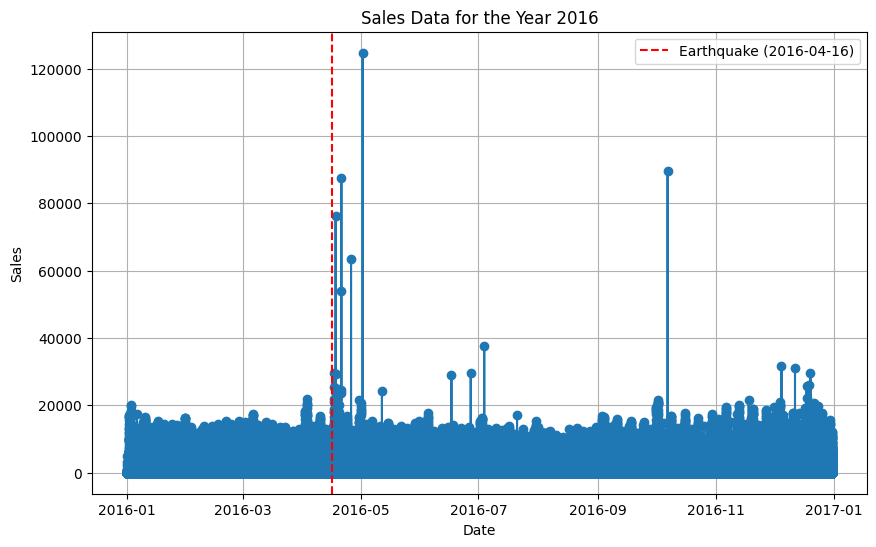

In [44]:
# Filter data for the year 2016
sales_2016 = train[train["date"].dt.year == 2016]

# Plotting the sales data for 2016 using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(sales_2016["date"], sales_2016["sales"], marker='o')
plt.axvline(pd.to_datetime("2016-04-16"), color='r', linestyle='--', label="Earthquake (2016-04-16)")
plt.title("Sales Data for the Year 2016")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

### From the visualization, the earthquake had a significant impact on sales. The high sales could be a response of the damage caused by the earthquake as people seek to get more supplies to ensure they are ready for any potential disruptions and also concerns about the availability of goods as earthquakes can disrupt supply chains and transportation networks.

### Are sales affected by promotions?

In [45]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0


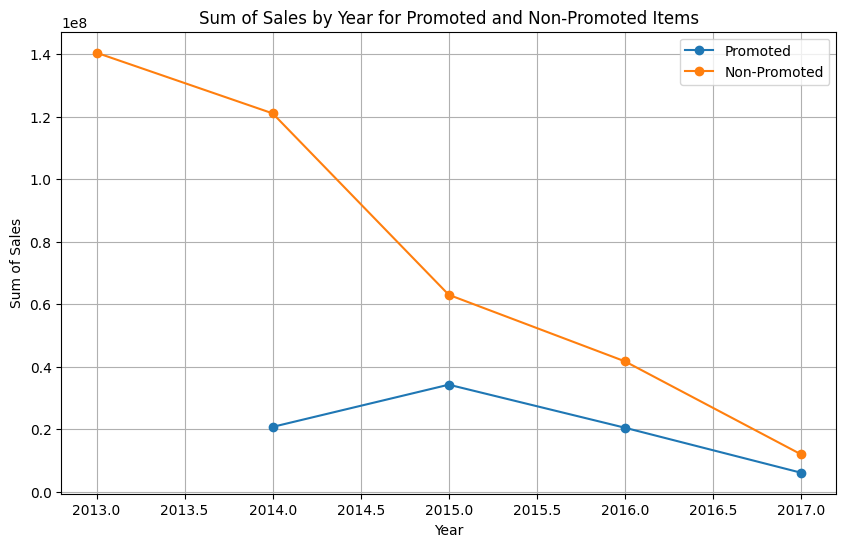

In [46]:
# Filter data for promoted and non-promoted items
promoted_items = train[train['onpromotion'] == 1]
non_promoted_items = train[train['onpromotion'] == 0]

# Group data by year and onpromotion, and calculate the sum of sales
promoted_sales_by_year = promoted_items.groupby([promoted_items["date"].dt.year, "onpromotion"])["sales"].sum().reset_index()
non_promoted_sales_by_year = non_promoted_items.groupby([non_promoted_items["date"].dt.year, "onpromotion"])["sales"].sum().reset_index()

# Plotting the sum of sales for promoted and non-promoted items by year using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(promoted_sales_by_year[promoted_sales_by_year["onpromotion"] == 1]["date"],
         promoted_sales_by_year[promoted_sales_by_year["onpromotion"] == 1]["sales"],
         marker='o', label="Promoted")
plt.plot(non_promoted_sales_by_year[non_promoted_sales_by_year["onpromotion"] == 0]["date"],
         non_promoted_sales_by_year[non_promoted_sales_by_year["onpromotion"] == 0]["sales"],
         marker='o', label="Non-Promoted")
plt.title("Sum of Sales by Year for Promoted and Non-Promoted Items")
plt.xlabel("Year")
plt.ylabel("Sum of Sales")
plt.grid(True)
plt.legend()
plt.show()


### The visualization above shows that the grocery store make more sales for items not on promotion compared to items on promotion. however, their is a consistent decline in sales figures of non-promoted items from 2013 to 2017 which could have been due to changes in market conditions, competition, customer preferences, or economic factors.for the promoted items sales figures increase from 2014 to 2015, before a consistent decline from 2015 to 2017. Hence, we can conclude that their is a decreasimg trend on sales data.

### What are the best-selling products?

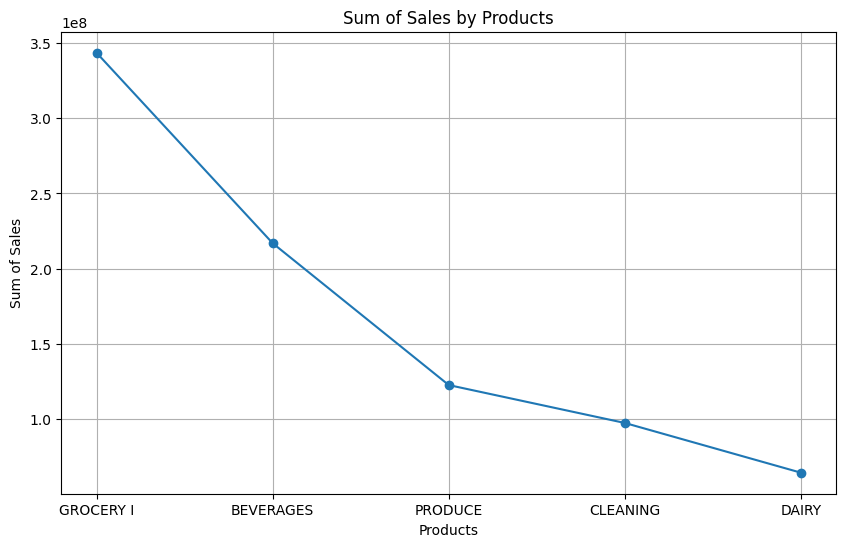

In [47]:
# Group data by products and sales, and calculate the sum of sales
best_selling_products = train.groupby('family')["sales"].sum().reset_index().sort_values(by="sales", ascending=False).head(5)

# Plotting the sum of sales for products
plt.figure(figsize=(10, 6))
plt.plot(best_selling_products['family'], best_selling_products['sales'], marker='o')
plt.title("Sum of Sales by Products")
plt.xlabel("Products")
plt.ylabel("Sum of Sales")
plt.grid(True)
plt.show()


### The top 5 selling products are Grocery1, Bevarages, Produce, Cleaning and Dairy products. The store has sold Grocery1 items worth about $340,000,000.

### Are certain groups of stores selling more products? 

In [48]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0


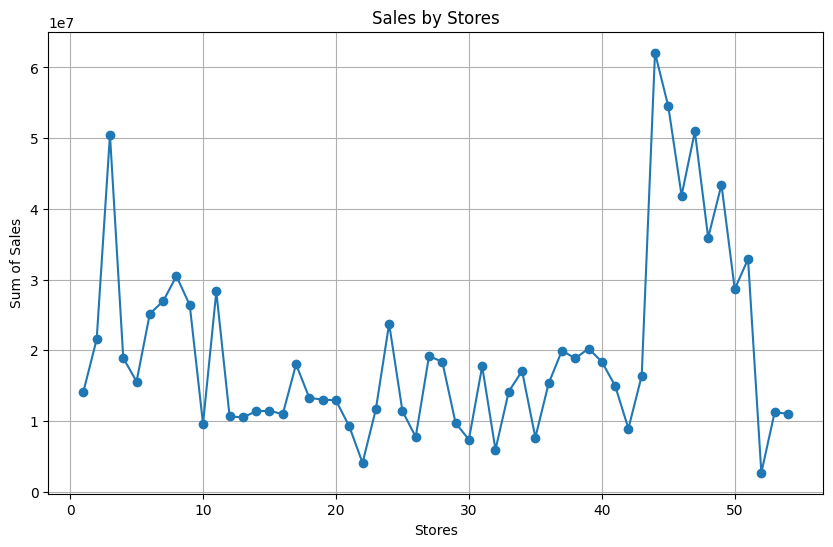

In [49]:
# Group data by stores and sales, and calculate the sum of sales
stores_sales = train.groupby('store_nbr')["sales"].sum().reset_index()

# Plotting the sum of sales for products
plt.figure(figsize=(10, 6))
plt.plot(stores_sales['store_nbr'], stores_sales['sales'], marker='o')
plt.title("Sales by Stores")
plt.xlabel("Stores")
plt.ylabel("Sum of Sales")
plt.grid(True)
plt.show()

### The visualization shows that some stores are selling more products compared to others. The sales of most stores is below 30,000,000 while others, such as store 3, 44 and 45 are highest performers and make sales of about $50,000,000, $62,000,000 and $55,000,000 respectively. The variation in sales could be influenced by the store's location or other internal factors.

### Which days have the most sales?

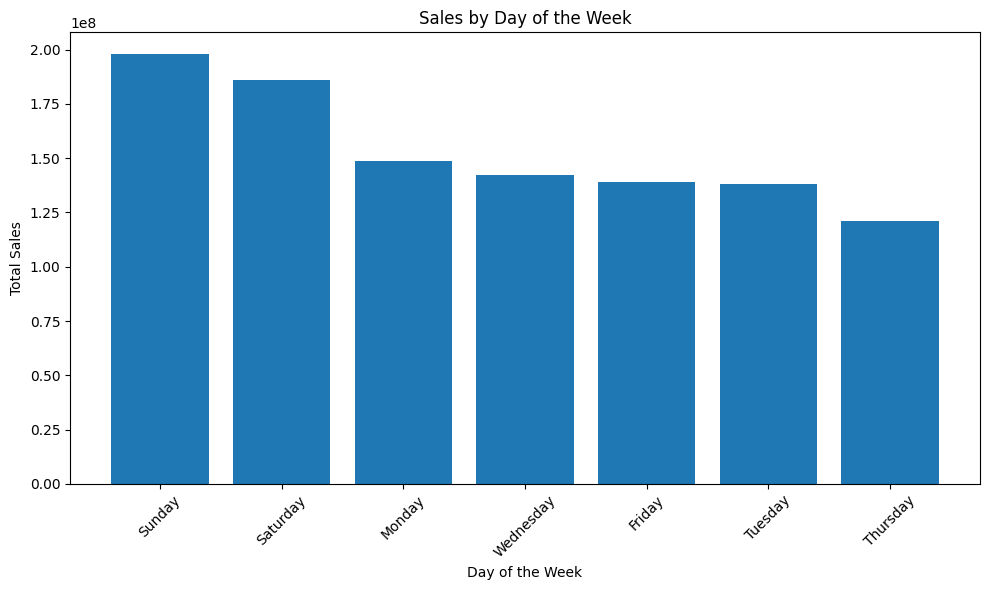

In [50]:
# Group the data by the day of the week and calculate the sum of sales for each day
train["DayOfWeek"] = train["date"].dt.day_name()
weekly_sales = train.groupby("DayOfWeek")["sales"].sum().reset_index().sort_values(by='sales', ascending=False)

# Plotting the sales for each day of the week using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(weekly_sales["DayOfWeek"], weekly_sales["sales"])
plt.title("Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### The store makes most sales during the weekend, that is Saturday and Sunday, with highest sales observed on Sunday and lowest sales observed on Thursday.

## Transaction Dataset

In [51]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


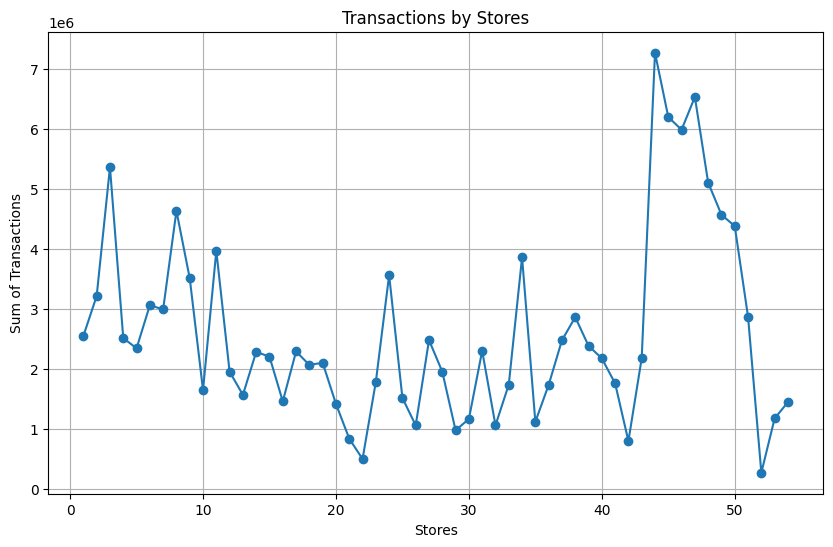

In [52]:
# Group data by stores and transaction, and calculate the sum of transactions
stores_transaction = transactions.groupby('store_nbr')["transactions"].sum().reset_index()

# Plotting the sum of transaction for stores
plt.figure(figsize=(10, 6))
plt.plot(stores_transaction['store_nbr'], stores_transaction['transactions'], marker='o')
plt.title("Transactions by Stores")
plt.xlabel("Stores")
plt.ylabel("Sum of Transactions")
plt.grid(True)
plt.show()

### The sum of transactions of most stores is below 3000000 with store 44 recording an impressive number of 7,250,000 transactions followed closely by store 47 with 6,600,000 transactions and store 45 and 46. Store 3 also has lower but substantial transactions figure of about 5,400,000. The analysis highlights variations in transactions across different stores that can inform strategic decision-making for the retail store management. It assists in directing resources and efforts towards high-performing stores, thereby contributing to increased sales and overall profitability.

## Stores dataset


In [53]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


### What store is the highest performer in terms of sales

In [54]:
best_stores_sales = train.groupby('store_nbr')["sales"].sum().reset_index().sort_values(by='sales', ascending=False).head(5)
least_stores_sales = train.groupby('store_nbr')["sales"].sum().reset_index().sort_values(by='sales', ascending=False).tail(5)
print(best_stores_sales)
print(least_stores_sales)

    store_nbr         sales
43       44.0  6.208755e+07
44       45.0  5.449801e+07
46       47.0  5.094831e+07
2         3.0  5.048191e+07
48       49.0  4.342010e+07
    store_nbr         sales
34       35.0  7.676679e+06
29       30.0  7.382074e+06
31       32.0  5.951796e+06
21       22.0  4.090202e+06
51       52.0  2.696170e+06


### Store number 44 is the highest performer in terms of sales by $62,087,550 sales, while store number 52 is the least performer with $2,696,170 sales

### Data Merging
Lets merge the datasets to further analyse relationships

Merging Oil dataset

In [55]:
#check common columns in oil and train datasets
d=oil.columns.intersection(train.columns)
d

Index(['date'], dtype='object')

In [56]:
# split oil.csv on the dates that reflects the split for the test and train
#define the start and end dates for the oil.csv that will be joined to the test

oil_test_start_date= '2017-08-16'
oil_test_end_date= '2017-08-31'

oil_train = oil[oil['date'] < oil_test_start_date]
oil_test = oil[oil['date'].between (oil_test_start_date, oil_test_end_date)]

# Verify the split
range_oil_test = oil_test['date'].min(), oil_test['date'].max()
range_oil_train = oil_train['date'].min(), oil_train['date'].max()

print(range_oil_test)
print(range_oil_train)

(Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-31 00:00:00'))
(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))


In [57]:
# merge test and oil_test on 'date'

merged_test = pd.merge(test, oil_test, on='date', how='left')
print(merged_test.head())

        id       date  store_nbr      family  onpromotion  oil_prices
0  3000888 2017-08-16          1  AUTOMOTIVE            0   46.799999
1  3000889 2017-08-16          1   BABY CARE            0   46.799999
2  3000890 2017-08-16          1      BEAUTY            2   46.799999
3  3000891 2017-08-16          1   BEVERAGES           20   46.799999
4  3000892 2017-08-16          1       BOOKS            0   46.799999


In [58]:
merged_test.shape

(28512, 6)

In [59]:
#check for null or missing values

merged_test.isnull().sum()

id                0
date              0
store_nbr         0
family            0
onpromotion       0
oil_prices     7128
dtype: int64

In [60]:
# merge train and oil_train on 'date'

merged_train = pd.merge(train, oil_train, on='date', how='left')
print(merged_train.head())

       id       date  store_nbr        family  sales  onpromotion DayOfWeek  \
0     0.0 2013-01-01        1.0    AUTOMOTIVE    0.0          0.0   Tuesday   
1  1194.0 2013-01-01       42.0   CELEBRATION    0.0          0.0   Tuesday   
2  1193.0 2013-01-01       42.0  BREAD/BAKERY    0.0          0.0   Tuesday   
3  1192.0 2013-01-01       42.0         BOOKS    0.0          0.0   Tuesday   
4  1191.0 2013-01-01       42.0     BEVERAGES    0.0          0.0   Tuesday   

   oil_prices  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [61]:
merged_train.shape

(3000892, 8)

In [62]:
#check for null or missing values

merged_train.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
DayOfWeek           0
oil_prices     928426
dtype: int64

Merging holiday dataset

In [63]:
#check common columns in holiday and train datasets
d=holiday.columns.intersection(train.columns)
d

Index(['date'], dtype='object')

In [64]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,DayOfWeek
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Tuesday
1194,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,Tuesday
1193,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,Tuesday
1192,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,Tuesday
1191,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,Tuesday


In [66]:
# split holiday.csv on the dates that reflects the split for the test and train
#define the start and end dates for the holiday.csv that will be joined to the test
holiday_train_start_date= '2013-01-01'
holiday_train_end_date= '2017-08-15'
holiday_test_start_date= '2017-08-16'
holiday_test_end_date= '2017-08-31'

holiday_train = holiday[holiday['date'].between (holiday_train_start_date, holiday_train_end_date)]
holiday_test = holiday[holiday['date'].between (holiday_test_start_date, holiday_test_end_date)]

# Verify the split
range_holiday_test = holiday_test['date'].min(), holiday_test['date'].max()
range_holiday_train = holiday_train['date'].min(), holiday_train['date'].max()

print(range_holiday_test)
print(range_holiday_train)

(Timestamp('2017-08-24 00:00:00'), Timestamp('2017-08-24 00:00:00'))
(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))


In [70]:
# merge train and holiday_train on 'date'

merged2_train = pd.merge(merged_train, holiday_train, on='date', how='left')
merged2_train.head()

,id,date,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,type,locale,locale_name,description,transferred
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [71]:
merged2_train.shape

(3054352, 13)

In [72]:
merged2_train.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
DayOfWeek            0
oil_prices      955156
type           2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

In [73]:
# merge test and holiday_test on 'date'

merged2_test = pd.merge(merged_test, holiday_test, on='date', how='left')
merged2_test.head()

,id,date,store_nbr,family,onpromotion,oil_prices,type,locale,locale_name,description,transferred
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.799999,NaN,NaN,NaN,NaN,NaN
1,3000889,2017-08-16,1,BABY CARE,0,46.799999,NaN,NaN,NaN,NaN,NaN
2,3000890,2017-08-16,1,BEAUTY,2,46.799999,NaN,NaN,NaN,NaN,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,46.799999,NaN,NaN,NaN,NaN,NaN
4,3000892,2017-08-16,1,BOOKS,0,46.799999,NaN,NaN,NaN,NaN,NaN


In [74]:
merged2_test.shape

(28512, 11)

In [75]:
# check for missing values
merged2_test.isna().sum()

id                 0
date               0
store_nbr          0
family             0
onpromotion        0
oil_prices      7128
type           26730
locale         26730
locale_name    26730
description    26730
transferred    26730
dtype: int64

merging stores and train datasets

In [76]:

#check common columns in stores  and train datasets
d=stores.columns.intersection(train.columns)
d

Index(['store_nbr'], dtype='object')

In [77]:
# merge stores and train datasets
merge3_train = pd.merge(merged2_train, stores, on='store_nbr', how='left')
merge3_train.head()

,id,date,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2


In [78]:
# split merged_transactions.csv on the dates that reflects the split for the test and train
#define the start and end dates that will be joined to the test

transaction_test_start_date= '2017-08-16'
transaction_test_end_date= '2017-08-31'

transaction_train = transactions[transactions['date'] < transaction_test_start_date]
transaction_test = transactions[transactions['date'].between (transaction_test_start_date, transaction_test_end_date)]

# Verify the split
range_transaction_test = transaction_test['date'].min(), transaction_test['date'].max()
range_transaction_train = transaction_train['date'].min(), transaction_train['date'].max()

print(range_transaction_test)
print(range_transaction_train)

(NaT, NaT)
(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))


In [79]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


The transaction dates spans within the period of train data. hence, it will only be used for analysis

In [80]:
# merge train and transaction_train on 'date'

merged3_train = pd.merge(merge3_train, transactions, on=['date','store_nbr'], how='left')
merged3_train.head()

,id,date,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster,transactions
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN


In [81]:
merged3_train.shape

(3054352, 18)

In [82]:
# check for missing values
merged3_train.isna().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
DayOfWeek             0
oil_prices       955156
type_x          2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
city                  0
state                 0
type_y                0
cluster               0
transactions     249121
dtype: int64

In [83]:
# rename type columns to holiday and stores type
merged3_train = merged3_train.rename(columns={'type_x': 'holiday_type'})
merged3_train = merged3_train.rename(columns={'type_y': 'stores_type'})

In [84]:
merged3_train.head()

,id,date,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,holiday_type,locale,locale_name,description,transferred,city,state,stores_type,cluster,transactions
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,1194.0,2013-01-01,42.0,CELEBRATION,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2,1193.0,2013-01-01,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
3,1192.0,2013-01-01,42.0,BOOKS,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
4,1191.0,2013-01-01,42.0,BEVERAGES,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN


merging stores and test datasets

In [85]:
#check common columns in stores  and test datasets
d=stores.columns.intersection(test.columns)
d

Index(['store_nbr'], dtype='object')

In [86]:
# merge test and stores on 'date'

merged3_test = pd.merge(merged2_test, stores, on='store_nbr', how='left')
merged3_test.head()

,id,date,store_nbr,family,onpromotion,oil_prices,type_x,locale,locale_name,description,transferred,city,state,type_y,cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,0,46.799999,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,0,46.799999,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,2,46.799999,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,20,46.799999,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,0,46.799999,NaN,NaN,NaN,NaN,NaN,Quito,Pichincha,D,13


In [87]:
merged3_test.isna().sum()

id                 0
date               0
store_nbr          0
family             0
onpromotion        0
oil_prices      7128
type_x         26730
locale         26730
locale_name    26730
description    26730
transferred    26730
city               0
state              0
type_y             0
cluster            0
dtype: int64

In [88]:
merged3_test = merged3_test.rename(columns={'type_x': 'holiday_type'})
merged3_test = merged3_test.rename(columns={'type_y': 'stores_type'})

In [89]:
# Set the 'date' column as the index
merged3_train.set_index('date', inplace=True)

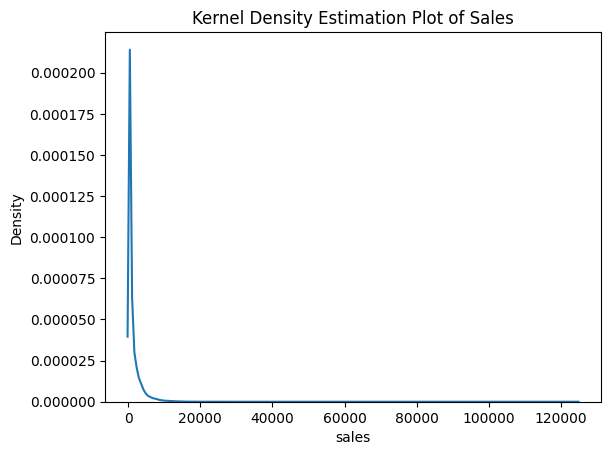

In [90]:
# check for distribution in sales
# Create a KDE plot for the 'sales' variable
sns.kdeplot(x='sales',data=merged3_train)
plt.title('Kernel Density Estimation Plot of Sales')

# Display the plot
plt.show()


KDE is a non-parametric way to estimate the probability density function of a continuous variable, in this case, the "sales" variable.The shape of the curve is unimodal (one peak) indicating a central tendency in sales, and the distribution is symmetric, skewed right (positively skewed) suggesting that the mean (average) is typically greater than the median (middle value when the data is ordered from smallest to largest). we can also observe that sales are most concentrated between 0 and 3000. The narrower curve suggests less variability in sales while the long tail suggests the presence of few extremely large values (outliers). Certain statistical tests and models assume normality, so skewed data might require transformation before analysis. In summary, a positively skewed distribution suggests that the data is not symmetrical and has a long right tail.

Checking for Trend, Seasonality, Irregularity and Cyclic Components

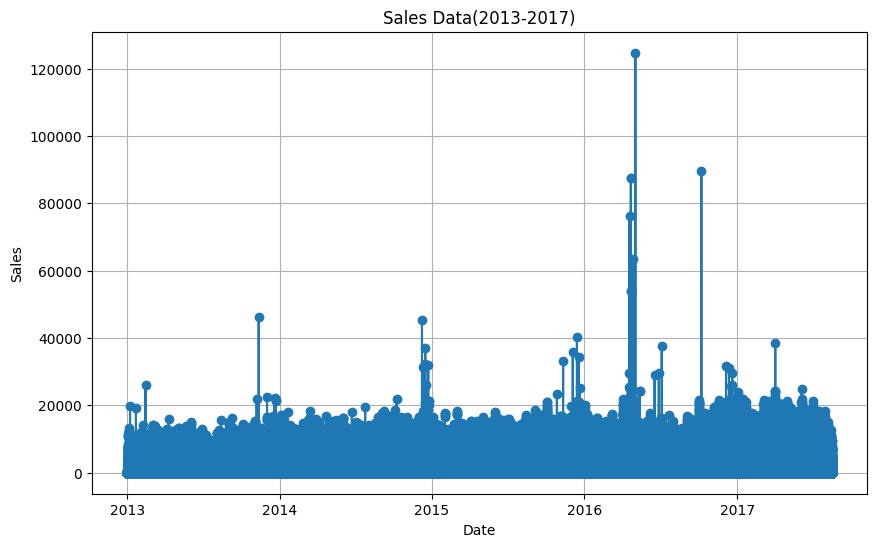

In [91]:
# checking for Trend,seasonality in sales date
plt.figure(figsize=(10, 6))
plt.plot(merged3_train.index, merged3_train["sales"], marker='o')
plt.title("Sales Data(2013-2017)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

There is no clear trend in the data, however in 2014 and 2015 we can observe an upward trend in sales, where sales are ralatively low in the data. There is also a repeating pattern in sales at the end of each year where sales are relatively high. hence, we conclude that their is seasonality in the data. it is also observed that there is non-repeating patterns or random variations particularly in 2016 and 2017, where sales are relatively high in the middle of the year. hence, we conclude that their is irregularity in the data. 

### Resampling

Resampling involves changing the frequency or granularity of your time series data by aggregating it over different time intervals. This will allow deep analysis of the data.

In [92]:
# Resample sales to monthly and weekly data 
monthly_df = merged3_train['sales'].resample('M').mean()
weekly_df= merged3_train['sales'].resample('W').mean()

In [93]:
# Resample transactions to monthly and weekly data 
monthly_tn = merged3_train['transactions'].resample('M').mean()
weekly_tn= merged3_train['transactions'].resample('W').mean()

In [94]:
monthly_df.head()

date
2013-01-31    186.952405
2013-02-28    193.581846
2013-03-31    206.880581
2013-04-30    205.639071
2013-05-31    210.184563
Freq: M, Name: sales, dtype: float64

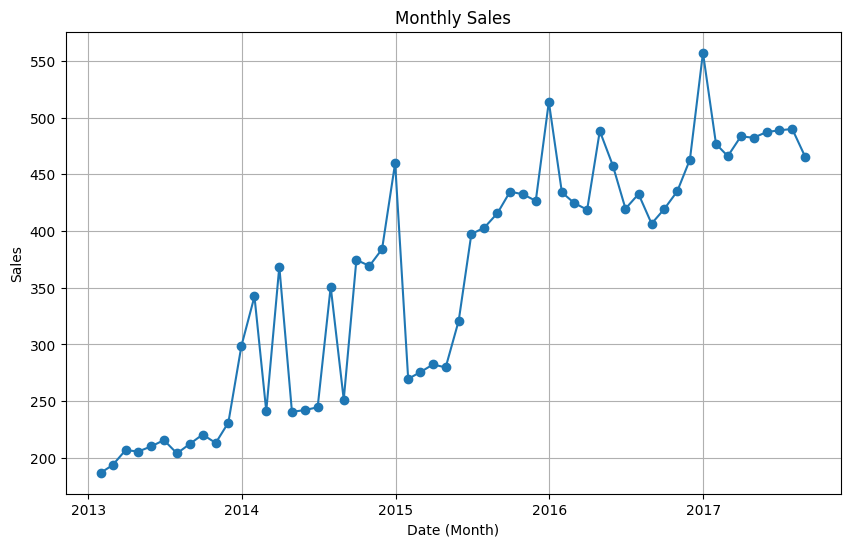

In [95]:
# lets look at the monthly sales to further understand the data
# Create a line plot of the monthly data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(monthly_df.index, monthly_df.values, marker='o', linestyle='-')
plt.title('Monthly Sales')
plt.xlabel('Date (Month)')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Here we can clearly see an upward trend in sales and seasonality, as sales peak at the end of each year. There are also random variations or unexplained fluctuations in the data that cannot be attributed to any systematic pattern as seen in 2014 and 2016, hence, irregularity or random noise in the data.

In [96]:
weekly_df.head()

date
2013-01-06    206.843478
2013-01-13    190.285220
2013-01-20    189.835452
2013-01-27    182.152050
2013-02-03    198.564267
Freq: W-SUN, Name: sales, dtype: float64

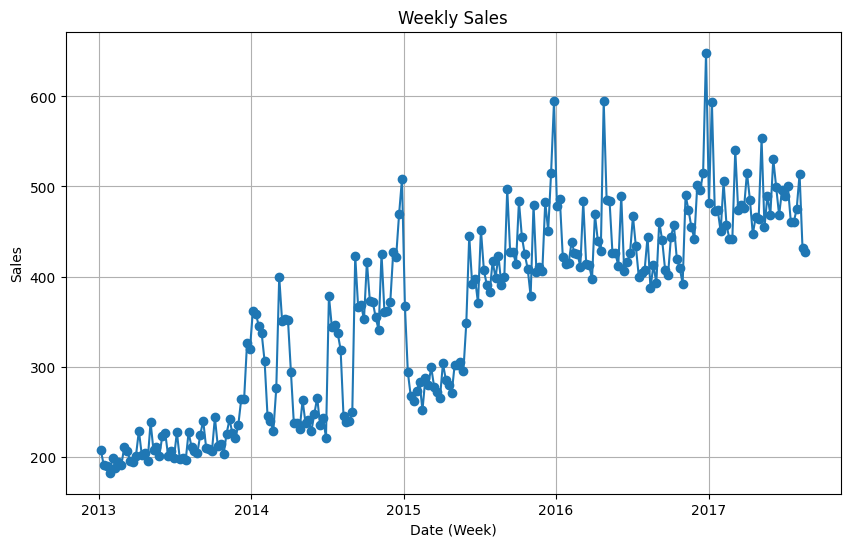

In [97]:
# lets look at the weekly sales to further understand the data
# Create a line plot of the weekly data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(weekly_df.index, weekly_df.values, marker='o', linestyle='-')
plt.title('Weekly Sales')
plt.xlabel('Date (Week)')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

we can see a downward and upward variations in weekly sales. Wages in the public sector are paid every two weeks on the 15th and on the last day of the month. Hence, the rising and declining pattern in sales could be affected by this.

### Sales and Transactions by Stores

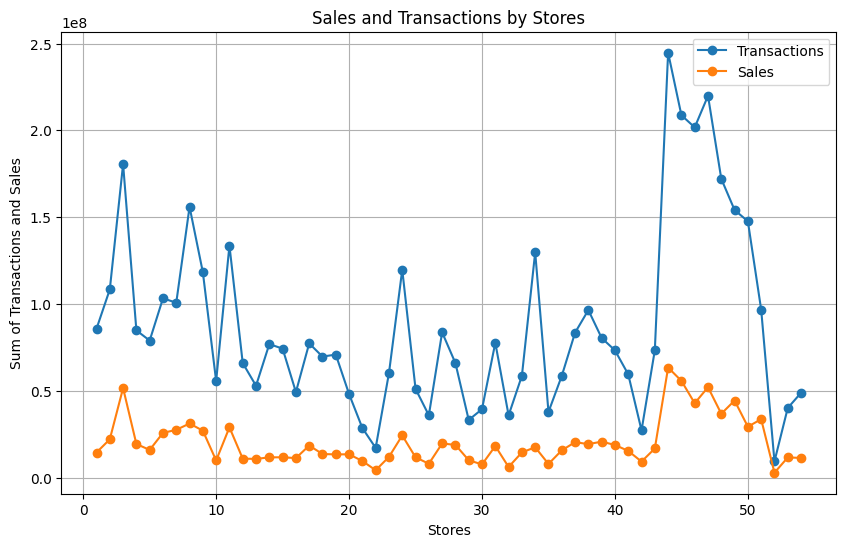

In [98]:
# Group data by stores and transaction, and calculate the sum of transactions
stores_transaction = merged3_train.groupby('store_nbr')["transactions"].sum().reset_index()
stores_sale = merged3_train.groupby('store_nbr')["sales"].sum().reset_index()

# Plotting the sum of transaction and sales for stores
plt.figure(figsize=(10, 6))
plt.plot(stores_transaction['store_nbr'], stores_transaction['transactions'], marker='o', label='Transactions')
plt.plot(stores_sale['store_nbr'], stores_sale['sales'], marker='o', label='Sales')
plt.title("Sales and Transactions by Stores")
plt.xlabel("Stores")
plt.ylabel("Sum of Transactions and Sales")

# Add a legend
plt.legend()

plt.grid(True)
plt.show()


### there is a similar pattern in sales and transactions in most stores. however, looking at other stores, such as store 34, despite having high transactions than most stores, its sales is slightly lower. a similar patter is observed with store 38, where despite having transactions higher than its subsequent stores, its sales is lower than those stores. store 48 also has higher transactions than store 49, but the sales of store 49 is higher than those of store 48. the analysis therefore shows variations in sales and transactions that the management could use to look at the factors contributing to lower sales in these stores despite having higher transactions.

In [99]:
merged3_train.head()

,id,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,holiday_type,locale,locale_name,description,transferred,city,state,stores_type,cluster,transactions
date,,,,,,,,,,,,,,,,,
2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2013-01-01,1194.0,42.0,CELEBRATION,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1193.0,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1192.0,42.0,BOOKS,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1191.0,42.0,BEVERAGES,0.0,0.0,Tuesday,NaN,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN


###	ARE CERTAIN GROUPS OF STORES SELLING MORE PRODUCTS? (CLUSTER, CITY, STATE, TYPE)

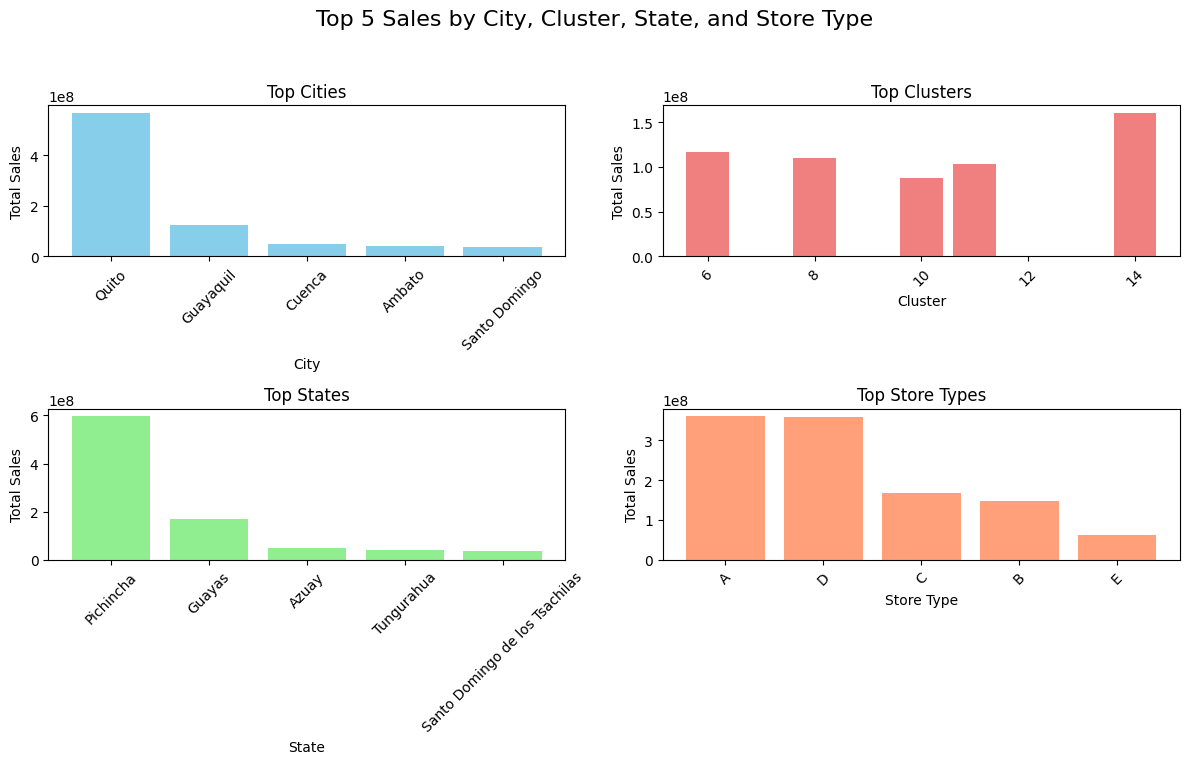

In [100]:
# Calculate total sales for the top 5 cities, clusters, states, and store types
top_cities = merged3_train.groupby('city')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_clusters = merged3_train.groupby('cluster')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_states = merged3_train.groupby('state')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()
top_store_types = merged3_train.groupby('stores_type')['sales'].sum().sort_values(ascending=False).nlargest(5).reset_index()

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Top 5 Sales by City, Cluster, State, and Store Type', fontsize=16)

# Plot top cities
axes[0, 0].bar(top_cities['city'], top_cities['sales'], color='skyblue')
axes[0, 0].set_title('Top Cities')
axes[0, 0].set_xlabel('City')
axes[0, 0].set_ylabel('Total Sales')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot top clusters
axes[0, 1].bar(top_clusters['cluster'], top_clusters['sales'], color='lightcoral')
axes[0, 1].set_title('Top Clusters')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Total Sales')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot top states
axes[1, 0].bar(top_states['state'], top_states['sales'], color='lightgreen')
axes[1, 0].set_title('Top States')
axes[1, 0].set_xlabel('State')
axes[1, 0].set_ylabel('Total Sales')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot top store types
axes[1, 1].bar(top_store_types['stores_type'], top_store_types['sales'], color='lightsalmon')
axes[1, 1].set_title('Top Store Types')
axes[1, 1].set_xlabel('Store Type')
axes[1, 1].set_ylabel('Total Sales')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()


The analysis of total sales based on different groupings reveals interesting insights into the performance of stores in various categories.

City Analysis: Among the cities, Quito is the top-performing city in terms of sales. Guayaquil follows with a substantial but lower total sales figure. This suggests that Quito and Guayaquil cities generate highest revenues for the retail store.

Cluster Analysis: For the clusters(store size), Cluster 14 is the top performing cluster in terms of revenue. Clusters 6, 8, 11, and 10 also perform well but slightly lower than 14. This analysis provides insights on variation in sales performance across different clusters, with no clear relationship between sales and cluster.

State Analysis: In regard to states, Pichincha is leading with highest total sales, followed by Guayas with a substantial but lower sales. This suggests that stores located in Pichincha and Guayas contribute significantly to the overall sales, reflecting the regional variations in sales performance.

Store Type Analysis: Among the store types, type A lead in total sales, indicating that they generate the highest revenue followed closely by type D. This suggests that type A and D generates highest revenues for the retail store.

To sum it up, this analysis provides valuable insights that can inform strategic decision-making for the retail store management. It assists in directing resources and efforts towards high-performing segments, thereby contributing to increased sales and overall profitability.

### Impact of oil prices on sales

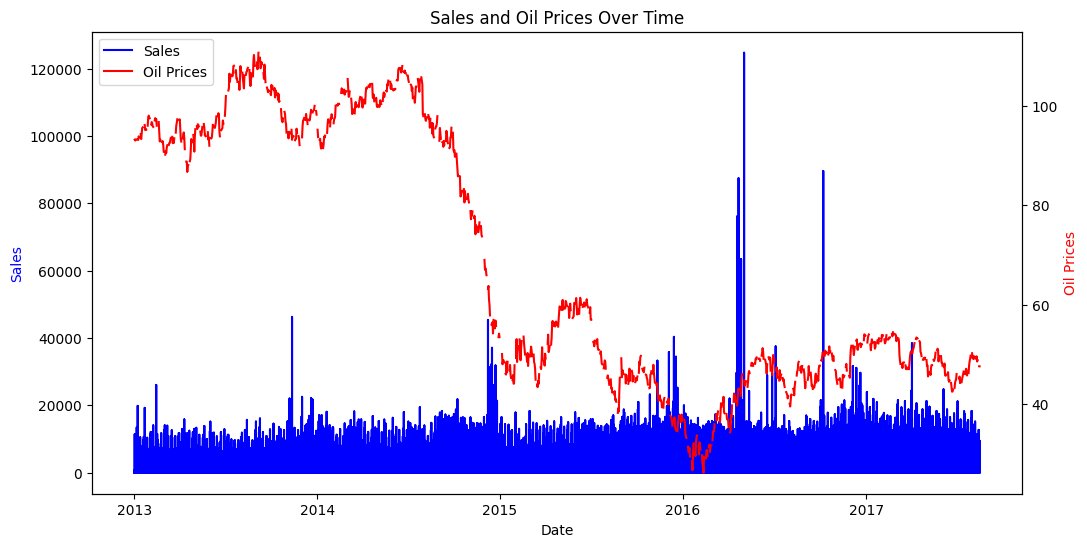

In [101]:
# lets plot oil prices against sales

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot sales data as a blue line
ax.plot(merged3_train.index, merged3_train['sales'], color='blue', label='Sales')

# Add a secondary y-axis for oil prices
ax2 = ax.twinx()  # Create a twin axis that shares the same x-axis

# Plot oil prices data as a red line on the secondary axis
ax2.plot(merged3_train.index, merged3_train['oil_prices'], color='red', label='Oil Prices')

# Set labels and legends for both axes
ax.set_xlabel('Date')
ax.set_ylabel('Sales', color='blue')
ax2.set_ylabel('Oil Prices', color='red')

# Add legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

# Set a title
plt.title('Sales and Oil Prices Over Time')

# Display the plot
plt.show()


The relationship between sales and oil prices is complex and can be influenced by various factors. Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices. From the visualization the relationship is not clear. hence, lets test the correlation between two variables to determine the relationship.

Imputing Nan values in oil_prices
Since 'oil_prices' is a time series column, and considering the trend, we will consider Time-Based Imputation to impute missing values based on the values at adjacent time points. This will involve using the previous or next available value, or even interpolating between nearby values.

In [102]:
merged3_train['oil_prices'].interpolate(method='time', inplace=True)  # Interpolate based on time

In [103]:
merged3_train['oil_prices'].isna().sum()

1782

In [104]:
# we still have missing values after interpolating
merged3_train['oil_prices'].fillna(method='bfill', inplace=True)  # imputing with backward fill

In [105]:
merged3_train['oil_prices'].isna().sum()

0

Null Hypothesis (H0): There is no correlation between sales and oil prices (ρ = 0).
Alternative Hypothesis (Ha): There is a correlation between sales and oil prices (ρ ≠ 0).

In [106]:
# 'sales' and 'oil_prices' are the two variables to be tested
correlation_coefficient, p_value = stats.pearsonr(merged3_train['sales'], merged3_train['oil_prices'])

# 'correlation_coefficient' contains the Pearson correlation coefficient
# 'p_value' contains the p-value associated with the correlation

# Interpret the results
if p_value < 0.05:  # Adjust significance level as needed
    print(f"There is a statistically significant correlation (ρ = {correlation_coefficient:.2f}).")
else:
    print("There is no statistically significant correlation between sales and oil prices.")


There is a statistically significant correlation (ρ = -0.08).


Interpretation:

The p-value is less than the significance level (0.05), we conclude that there is a statistically significant correlation between sales and oil prices. The correlation coefficient (ρ) indicates the strength and direction of the correlation. a negative ρ indicates a negative correlation. -0.08 indicates a weak negative correlation. In this scenario, rising oil prices could lead to decreased consumer spending, as higher fuel costs can reduce disposable income.




### Impact of Holidays on Sales

In [107]:
merged3_train.head()

,id,store_nbr,family,sales,onpromotion,DayOfWeek,oil_prices,holiday_type,locale,locale_name,description,transferred,city,state,stores_type,cluster,transactions
date,,,,,,,,,,,,,,,,,
2013-01-01,0.0,1.0,AUTOMOTIVE,0.0,0.0,Tuesday,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2013-01-01,1194.0,42.0,CELEBRATION,0.0,0.0,Tuesday,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1193.0,42.0,BREAD/BAKERY,0.0,0.0,Tuesday,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1192.0,42.0,BOOKS,0.0,0.0,Tuesday,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN
2013-01-01,1191.0,42.0,BEVERAGES,0.0,0.0,Tuesday,93.139999,Holiday,National,Ecuador,Primer dia del ano,False,Cuenca,Azuay,D,2,NaN


In [108]:
merged3_train['holiday_type'].value_counts()

holiday_type
Holiday       304726
Event          99792
Additional     67716
Transfer       16038
Work Day        8910
Bridge          5346
Name: count, dtype: int64

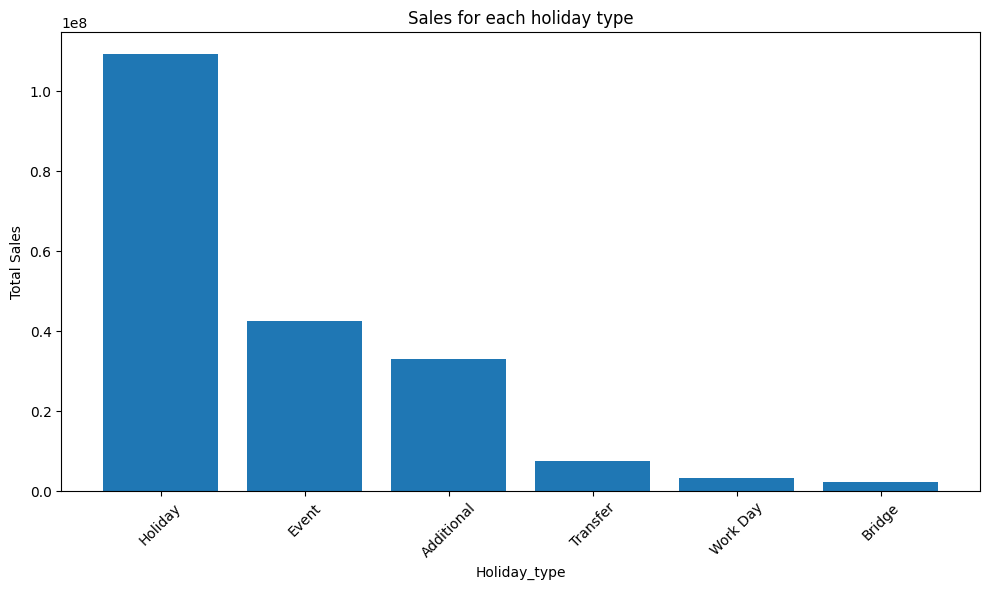

In [109]:
holiday_sales = merged3_train.groupby('holiday_type')['sales'].sum().sort_values(ascending=False).reset_index()

# Plotting the sales for each holiday type using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(holiday_sales["holiday_type"], holiday_sales["sales"])
plt.title("Sales for each holiday type")
plt.xlabel("Holiday_type")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### From the visualization, holidays have an impact on sales, where holidays recorded high sales of $109,222,700. Event and Additional days, which are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday) also recorded a substantial but relatively low sales of $42,477,470 and $33,020,280 respectively.

In [110]:
holiday_sales

,holiday_type,sales
0,Holiday,1.092227e+08
1,Event,4.247747e+07
2,Additional,3.302028e+07
3,Transfer,7.501824e+06
4,Work Day,3.315924e+06
5,Bridge,2.388330e+06


### Hypothesis testing

### Null Hypothesis (H0): There is no correlation between sales and promotion (ρ = 0).
### Alternative Hypothesis (Ha): There is a correlation between sales and promotions (ρ ≠ 0).

In [111]:
# 'sales' and 'onpromotion' are the two variables to be tested
correlation_coefficient, p_value = stats.pearsonr(merged3_train['sales'], merged3_train['onpromotion'])

# 'correlation_coefficient' contains the Pearson correlation coefficient
# 'p_value' contains the p-value associated with the correlation

# Interpret the results
if p_value < 0.05:  # Adjust significance level as needed
    print(f"There is a statistically significant correlation (ρ = {correlation_coefficient:.2f}).")
else:
    print("There is no statistically significant correlation between sales and promotion of products.")


There is a statistically significant correlation (ρ = 0.43).


Interpretation:

The p-value is less than the significance level (0.05), we conclude that there is a statistically significant correlation between sales and onpromotion. The correlation coefficient (ρ) indicates the strength and direction of the correlation. a positive ρ indicates a positive correlation. 0.43 indicates a relatively strong correlation. In this scenario, Promotions positively impact product sales, leading to increased sales during promotional periods.

### Data Preprocessing

In [112]:
# lets first drop the transactions, and Day of week, as it will not be used for training
merged3_train.drop(['transactions','description','DayOfWeek','id'], axis=1, inplace= True)
merged3_test.drop('description', axis=1, inplace=True)

### Imputting Missing Values

In [113]:
# check for missing values
merged3_train.isna().sum()

store_nbr             0
family                0
sales                 0
onpromotion           0
oil_prices            0
holiday_type    2551824
locale          2551824
locale_name     2551824
transferred     2551824
city                  0
state                 0
stores_type           0
cluster               0
dtype: int64

Imputting missing values in train
Here we make an assumption that there were no holidays in the dates with missing vaues hence, we impute with 'No Holiday'.

In [114]:
# Create a SimpleImputer instance with the strategy to impute with 'No Holiday'
imputer = SimpleImputer(strategy='constant', fill_value='No Holiday')

# Specify the columns to impute
columns_to_impute = ['holiday_type', 'locale', 'locale_name', 'transferred']

# Apply imputation to the specified columns
merged3_train[columns_to_impute] = imputer.fit_transform(merged3_train[columns_to_impute])

Imputting missing values in test

In [115]:
merged3_test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
oil_prices       7128
holiday_type    26730
locale          26730
locale_name     26730
transferred     26730
city                0
state               0
stores_type         0
cluster             0
dtype: int64

In [116]:
# Set the 'date' column as the index in test
merged3_test.set_index('date', inplace=True)

In [117]:
merged3_test['oil_prices'].interpolate(method='time', inplace=True)  # Interpolate based on time
merged3_test[columns_to_impute] = imputer.transform(merged3_test[columns_to_impute])

In [118]:
merged3_test.isna().sum()

id              0
store_nbr       0
family          0
onpromotion     0
oil_prices      0
holiday_type    0
locale          0
locale_name     0
transferred     0
city            0
state           0
stores_type     0
cluster         0
dtype: int64

In [119]:
merged3_train['family'].value_counts()

family
PRODUCE                       92558
HOME CARE                     92557
SEAFOOD                       92557
AUTOMOTIVE                    92556
LADIESWEAR                    92556
HOME APPLIANCES               92556
CLEANING                      92556
DAIRY                         92556
DELI                          92556
EGGS                          92556
LINGERIE                      92556
HOME AND KITCHEN II           92556
HOME AND KITCHEN I            92556
HARDWARE                      92556
GROCERY II                    92556
GROCERY I                     92556
LAWN AND GARDEN               92556
MAGAZINES                     92556
LIQUOR,WINE,BEER              92556
CELEBRATION                   92556
MEATS                         92556
PERSONAL CARE                 92556
PET SUPPLIES                  92556
PLAYERS AND ELECTRONICS       92556
POULTRY                       92556
PREPARED FOODS                92556
SCHOOL AND OFFICE SUPPLIES    92556
BABY CARE            

Categorizing the family column

In [120]:
# define product category group
groups= {
    'Household Items': ['HOME CARE','CLEANING','HOME AND KITCHEN II','HOME AND KITCHEN I','PERSONAL CARE','PET SUPPLIES','BABY CARE','BEAUTY'],
    'Apparel and Fashion': ['LADIESWEAR','LINGERIE'],
    'Entertainment and Leisure': ['MAGAZINES','CELEBRATION','BOOKS'],
    'Hardware and Home tools': ['AUTOMOTIVE','HOME APPLIANCES','HARDWARE','LAWN AND GARDEN','PLAYERS AND ELECTRONICS','SCHOOL AND OFFICE SUPPLIES'],
    'Food and Bevarage': ['GROCERY I','GROCERY II','PRODUCE','SEAFOOD','DAIRY','DELI','EGGS','LIQUOR,WINE,BEER','MEATS','POULTRY','PREPARED FOODS','BEVERAGES','BREAD/BAKERY','FROZEN FOODS']

}

# create a product_category column based on mapping
merged3_train['product_category'] = merged3_train['family'].apply(lambda x: next((group for group, categories in groups.items() if x in categories),'other'))

In [121]:
# rename family to product
merged3_train.rename(columns={'family': 'product'}, inplace=True)
merged3_test.rename(columns={'family': 'product'}, inplace=True)


## Feature Selection
### here we conduct a correlation analysis to identify and remove variables that do not contribute to sales

### Testing Correlation between sales and categorical columns

In [122]:
cat_train= merged3_train.select_dtypes(include='object')
cat_train.columns

Index(['product', 'holiday_type', 'locale', 'locale_name', 'transferred',
       'city', 'state', 'stores_type', 'product_category'],
      dtype='object')

In [123]:

# 'sales' is continuous, and categorical columns include 'state', 'city', 'product', 'holiday', etc.

# Set your desired significance level
alpha = 0.05

# Create a list to store the results
results = []

# Create a list of categorical columns to test
categorical_columns = ['state', 'product','stores_type','city', 'holiday_type','product_category','transferred','locale','locale_name']

# Perform ANOVA tests for each categorical variable
for column in categorical_columns:
    # Group the DataFrame by the current categorical column
    grouped_data = [group['sales'] for name, group in merged3_train.groupby(column)]
    
    # Perform the ANOVA test
    result = stats.f_oneway(*grouped_data)
    
    # Append the result to the list of results
    results.append((column, result))
    
    # Check the p-value to determine significance and print it
    if result.pvalue < alpha:
        print(f"There is a significant difference in sales across {column}. p-value: {result.pvalue:.4f}")
    else:
        print(f"There is no significant difference in sales across {column}. p-value: {result.pvalue:.4f}")

There is a significant difference in sales across state. p-value: 0.0000
There is a significant difference in sales across product. p-value: 0.0000
There is a significant difference in sales across stores_type. p-value: 0.0000
There is a significant difference in sales across city. p-value: 0.0000
There is a significant difference in sales across holiday_type. p-value: 0.0000
There is a significant difference in sales across product_category. p-value: 0.0000
There is a significant difference in sales across transferred. p-value: 0.0000
There is a significant difference in sales across locale. p-value: 0.0000
There is a significant difference in sales across locale_name. p-value: 0.0000


### p-values are very close to 0.0000 (practically 0), it means that the observed data provides extremely strong evidence against the null hypothesis that the relationship between sales and any of the categorical variable is not significant. In other words, the results are highly statistically significant suggesting that there is a strong effect or difference in the data that is unlikely to have occurred by random chance alone.

### Testing correlation between sales and numeric variables

In [124]:
num_df= merged3_train.drop(['product', 'holiday_type', 'locale', 'locale_name', 'transferred',
       'city', 'state', 'stores_type', 'product_category'], axis=1)

In [125]:
num_df.columns

Index(['store_nbr', 'sales', 'onpromotion', 'oil_prices', 'cluster'], dtype='object')

<Axes: >

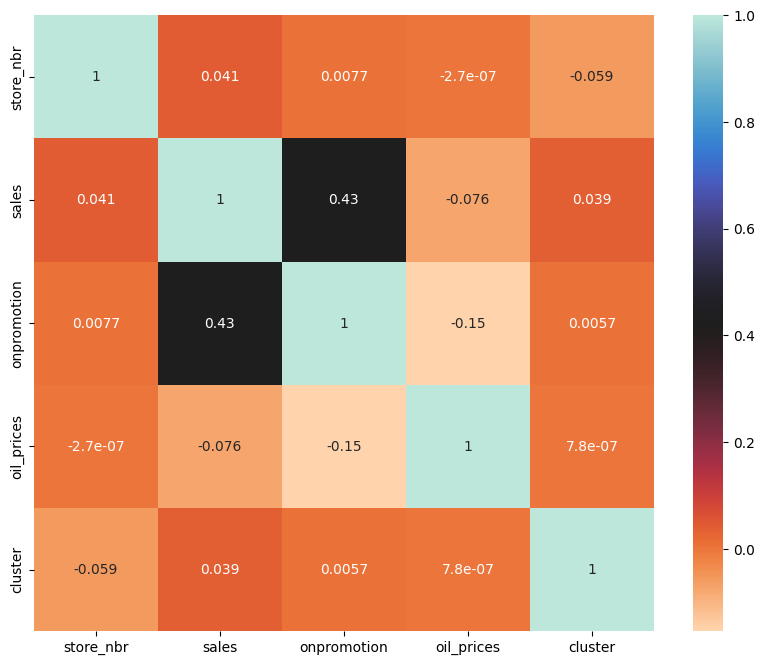

In [126]:
correlation = num_df.corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(correlation, annot = True,cmap='icefire_r')

In [127]:
# performing feature selection
coff=abs(correlation['sales'])
coff=coff[coff>0.01]
coff.sort_values(ascending=False)

sales          1.000000
onpromotion    0.428241
oil_prices     0.075570
store_nbr      0.041274
cluster        0.038537
Name: sales, dtype: float64

### The magnitude of the correlation value indicates the strength of the relationship. Larger absolute values (closer to 1) suggest stronger correlations, while values closer to 0 suggest weaker or no correlation. there is a strong correlation between sales and onpromotion. oil_prices, store_nbr nad cluster have weaker but substantial correlation with sales.

### Feature Engineering

Here we generate additional features that might improve the model's performance

In [128]:
# replace boolean values with strings to perform encoding
merged3_train['transferred'] = merged3_train['transferred'].replace({False: 'No', True: 'Yes'})
merged3_test['transferred'] = merged3_test['transferred'].replace({False: 'No', True: 'Yes'})

In [129]:

# Create additional columns for Year, Year-Month, Month, and Day for train
merged3_train['Year'] = merged3_train.index.year
merged3_train['Month'] = merged3_train.index.month
merged3_train['Day'] = merged3_train.index.day

In [130]:
# Create additional columns for Year, Year-Month, Month, and Day for test
merged3_test['Year'] = merged3_test.index.year
merged3_test['Month'] = merged3_test.index.month
merged3_test['Day'] = merged3_test.index.day

In [131]:
merged3_train.dtypes

store_nbr           float64
product              object
sales               float64
onpromotion         float64
oil_prices          float64
holiday_type         object
locale               object
locale_name          object
transferred          object
city                 object
state                object
stores_type          object
cluster               int64
product_category     object
Year                  int32
Month                 int32
Day                   int32
dtype: object

In [132]:
merged3_test.dtypes

id                int64
store_nbr         int64
product          object
onpromotion       int64
oil_prices      float64
holiday_type     object
locale           object
locale_name      object
transferred      object
city             object
state            object
stores_type      object
cluster           int64
Year              int32
Month             int32
Day               int32
dtype: object

## Decomposition

Time series decomposition is a statistical technique used to break down a time series into its underlying components. These components help us understand the various patterns and behaviors within a time series, making it easier to analyze, model, and forecast.

The primary components of a time series are typically:

1.Trend: The trend component represents the long-term movement or direction of the time series. It indicates whether the series is generally increasing, decreasing, or staying relatively stable over time. Removing the trend component helps isolate short-term fluctuations.

2.Seasonality: Seasonality refers to the repeating, predictable patterns or cycles in the time series that occur at fixed intervals. For example, retail sales might have a yearly seasonality pattern due to holiday shopping. Seasonality can occur at various frequencies, such as daily, weekly, monthly, or yearly.

3.Residual (or Error): The residual component, also known as the error term, represents the unexplained or random fluctuations in the time series after removing the trend and seasonality. It includes factors that are not accounted for by the trend and seasonality components.

Since the magnitude of seasonality remains roughly constant over time, and the variations around the trend are roughly constant we use Additive Decomposition where the original time series is represented as the sum of its components:

Original Time Series = Trend + Seasonality + Residual


In [133]:
# Perform additive decomposition
result_add = seasonal_decompose(merged3_train.groupby(merged3_train.index)['sales'].sum(), model='additive', extrapolate_trend='freq', period=12)

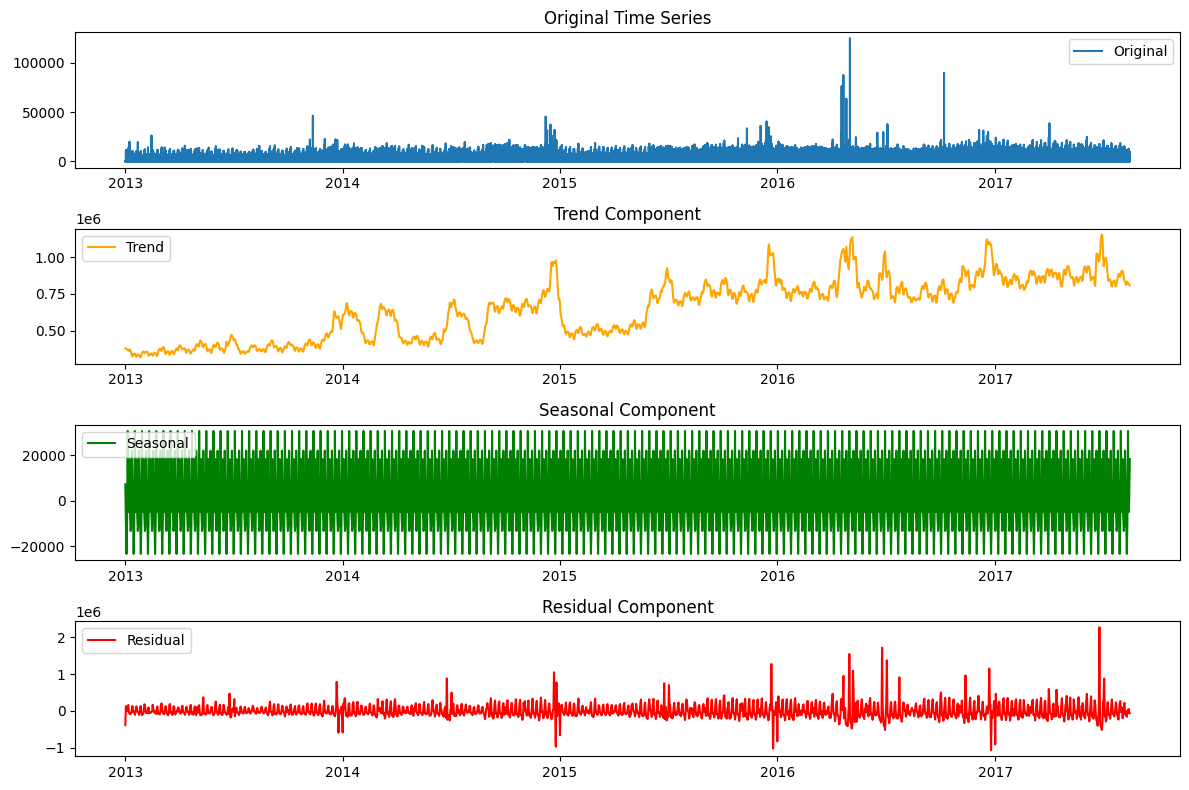

In [134]:

# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(411)  # 4 rows, 1 column, 1st subplot
plt.plot(merged3_train.index, merged3_train['sales'], label='Original')
plt.title('Original Time Series')
plt.legend()

# Plot the trend component
plt.subplot(412)  # 4 rows, 1 column, 2nd subplot
plt.plot(result_add.trend.index, result_add.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.legend()

# Plot the seasonal component
plt.subplot(413)  # 4 rows, 1 column, 3rd subplot
plt.plot(result_add.seasonal.index, result_add.seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

# Plot the residual component
plt.subplot(414)  # 4 rows, 1 column, 4th subplot
plt.plot(result_add.resid.index, result_add.resid, label='Residual', color='red')
plt.title('Residual Component')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


From the components plotted above, the trend of sales is clearly observed. The residuals show periods of high variability on sales.

1. Seasonal Component: although not clearly observed, it can be observed in the plot "Seasonal" that there are patterns that seems to be repeating over time. A further statistical test will be employed to confirm the seasonality of the sales.

2. Trend Component: The trend is clearly observed in the plot "Trend" with a that line shows a gradual increase in sales over time.

3. Residual Component: Residuals are what remains in your data after the trend and seasonality have been removed. It represents the random noise or fluctuations as shown in the plot. They capture irregularities or deviations from the expected trend and seasonality.

The use of an additive model assumes that these components (trend, seasonality, and residuals) can be combined in a straightforward manner to recreate the original time series values (in this case, sales data). This assumption implies that the interactions between these components are linear, meaning their effects can be summed together to reproduce the observed data.

### Data Sampling
The data points in the dataset are over 3 million an as we are limited by computational resources, we will sample and work with only 40% as our current system cannot handle the entire dataset.

In [135]:
# Define a function to perform the sampling
def train_sample(df, size):
    """
    Randomly samples rows from a DataFrame.

    Parameters:
     df (pd.DataFrame): DataFrame from which to sample.
     size (float): The proportion of rows to sample.

    Returns:
     pd.DataFrame: A sampled subset of DataFrame.
    """
    # Set a seed for reproducibility
    random.seed(42)

    # Calculate the number of rows to sample based on the specified size
    sample_size = int(size * len(df))

    # select rows randomly to create a sample
    sampled_data = df.sample(n=sample_size)

    return sampled_data

In [136]:
# Apply the function to sample the 40%
sampled_train = train_sample(merged3_train, 0.4)

In [137]:
sampled_train.shape

(1221740, 17)

In [138]:
sampled_train.head()

,store_nbr,product,sales,onpromotion,oil_prices,holiday_type,locale,locale_name,transferred,city,state,stores_type,cluster,product_category,Year,Month,Day
date,,,,,,,,,,,,,,,,,
2016-10-22,40.0,LAWN AND GARDEN,1.0,0.0,50.466667,No Holiday,No Holiday,No Holiday,No Holiday,Machala,El Oro,C,3,Hardware and Home tools,2016,10,22
2017-07-05,23.0,GROCERY I,2265.0,79.0,45.110001,No Holiday,No Holiday,No Holiday,No Holiday,Ambato,Tungurahua,D,9,Food and Bevarage,2017,7,5
2015-04-12,11.0,LADIESWEAR,0.0,0.0,51.843334,Holiday,Local,Cuenca,No,Cayambe,Pichincha,B,6,Apparel and Fashion,2015,4,12
2017-03-10,47.0,CLEANING,2331.0,8.0,48.049999,No Holiday,No Holiday,No Holiday,No Holiday,Quito,Pichincha,A,14,Household Items,2017,3,10
2014-01-14,46.0,POULTRY,647.4,0.0,92.150002,No Holiday,No Holiday,No Holiday,No Holiday,Quito,Pichincha,A,14,Food and Bevarage,2014,1,14


After sampling, the dataset now has 1221740 rows and 18 columns

In [139]:
sampled_train= sampled_train.sort_index()
sampled_train.head()

,store_nbr,product,sales,onpromotion,oil_prices,holiday_type,locale,locale_name,transferred,city,state,stores_type,cluster,product_category,Year,Month,Day
date,,,,,,,,,,,,,,,,,
2013-01-01,27.0,HOME CARE,0.0,0.0,93.139999,Holiday,National,Ecuador,No,Daule,Guayas,D,1,Household Items,2013,1,1
2013-01-01,54.0,FROZEN FOODS,0.0,0.0,93.139999,Holiday,National,Ecuador,No,El Carmen,Manabi,C,3,Food and Bevarage,2013,1,1
2013-01-01,35.0,SCHOOL AND OFFICE SUPPLIES,0.0,0.0,93.139999,Holiday,National,Ecuador,No,Playas,Guayas,C,3,Hardware and Home tools,2013,1,1
2013-01-01,23.0,MEATS,0.0,0.0,93.139999,Holiday,National,Ecuador,No,Ambato,Tungurahua,D,9,Food and Bevarage,2013,1,1
2013-01-01,23.0,GROCERY I,0.0,0.0,93.139999,Holiday,National,Ecuador,No,Ambato,Tungurahua,D,9,Food and Bevarage,2013,1,1


### Stationarity Testing

The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is a statistical test used in time series analysis to check the stationarity of a time series data set. Unlike the Augmented Dickey-Fuller (ADF) test, which tests for a unit root (non-stationarity), the KPSS test is designed to test for stationarity around a deterministic trend. In other words, it helps determine if a time series is stationary in levels (around a constant mean) or if it has a deterministic trend.

The KPSS test involves two hypotheses:

Null Hypothesis (H0): The null hypothesis of the KPSS test assumes that the time series is stationary around a deterministic trend. In other words, it assumes that the time series is stationary or trend-stationary.

Alternative Hypothesis (H1): The alternative hypothesis of the KPSS test assumes that the time series has a unit root or is non-stationary around a stochastic (random) trend. In other words, it assumes that the time series is non-stationary.

The test calculates a test statistic and compares it to critical values to determine whether to accept or reject the null hypothesis.

In [140]:
# Sales data
time_series = sampled_train['sales']

# Perform the KPSS Test with trend and constant
kpss_result = KPSS(time_series, trend='ct')

# Perform the ADF Test with trend and constant
adf_result = ADF(time_series, trend='ct')

In [141]:
kpss_result.summary()

Test Statistic,1.817
P-value,0.000
Lags,228


In [142]:
adf_result.summary()

Test Statistic,-72.010
P-value,0.000
Lags,127


looking at the results of both the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) and Augmented Dickey-Fuller (ADF) tests, we draw insights about the stationarity of the sales data. the test statistic of the ADF test is -73.476, which is remarkably low with a corresponding p-value of 0.000, below significance levels. Hence, we reject the null hypothesis that the sales time series contains a unit root, implying the sales series is weakly stationary,providing evidence on non-stationarity.

On the other hand, the KPSS test produced a test statistic of 1.885 and a p-value of 0.000, which is lower than the significance levels. Hence, we reject the null hypothesis, suggesting that the time series is not stationary around a deterministic trend and constant, implying non-stationarity. in conclusion, both of these results suggest that the sales time series data exhibits evidence of non-stationarity.

## Difference the Time Series.

Differencing is a technique used to transform a non-stationary time series into a stationary one

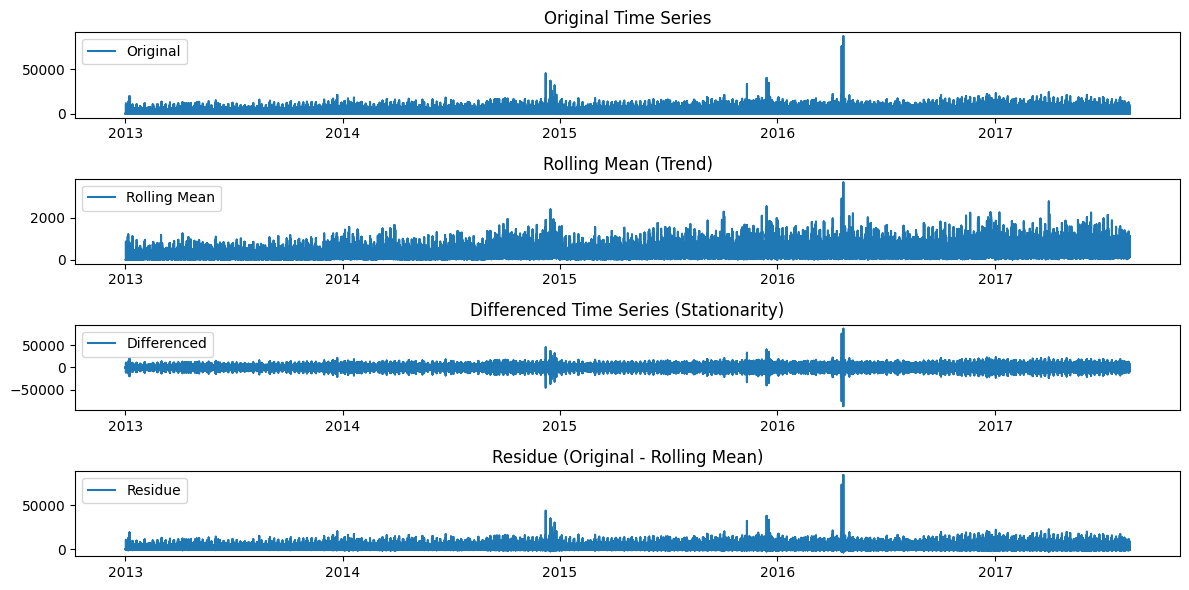

In [143]:


# Plot the original time series
plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(sampled_train['sales'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Calculate and plot rolling mean (trend)
plt.subplot(412)
rolling_mean = sampled_train['sales'].rolling(window=30).mean()  # Adjust the window size as needed
plt.plot(rolling_mean, label='Rolling Mean')
plt.legend(loc='upper left')
plt.title('Rolling Mean (Trend)')

# Calculate and plot differenced time series (stationarity)
plt.subplot(413)
sampled_train['diff'] = sampled_train['sales'].diff(periods=1).fillna(0)  # Adjust the differencing order as needed
plt.plot(sampled_train['diff'], label='Differenced')
plt.legend(loc='upper left')
plt.title('Differenced Time Series (Stationarity)')

# Calculate and plot residue (original minus rolling mean)
plt.subplot(414)
residue = sampled_train['sales'] - rolling_mean
plt.plot(residue, label='Residue')
plt.legend(loc='upper left')
plt.title('Residue (Original - Rolling Mean)')

plt.tight_layout()
plt.show()

In [144]:
# display results
sampled_train[['sales', 'diff']].tail(5).style.set_caption('Sampled_train Time Series')


,sales,diff
date,,
2017-08-15 00:00:00,8.000000,-176.000000
2017-08-15 00:00:00,0.000000,-8.000000
2017-08-15 00:00:00,135.858000,135.858000
2017-08-15 00:00:00,35.000000,-100.858000
2017-08-15 00:00:00,1.000000,-34.000000


conducting statistical test to check whether the series is stationary after differencing

In [145]:

# check for stationarity
result = kpss(sampled_train['diff'], regression='c')  # 'c' for a constant trend
p_value = result[1]

if p_value > 0.05:
    print("The differenced data is stationary (p-value =", p_value, ")")
else:
    print("The differenced data is not stationary (p-value =", p_value, ")")

The differenced data is stationary (p-value = 0.1 )


## Autocorrelation Test

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are important tools in time series analysis for understanding and modeling the relationships between observations at different time lags. These functions help analysts identify the order of autoregressive (AR) and moving average (MA) components in a time series model, which is essential for building accurate forecasting models.

Autocorrelation Function (ACF):

The ACF measures the correlation between a time series and its own lagged values.
It calculates the correlation coefficient between the time series at time "t" and the same series at various previous time points (lags).
The ACF is used to identify the order of the MA (moving average) component in a time series model.
In the ACF plot, significant spikes at specific lags indicate potential AR or MA orders.

Partial Autocorrelation Function (PACF):

The PACF measures the correlation between a time series and its own lagged values, while controlling for the intermediate lags.
It helps identify the direct relationship between a data point at time "t" and its value at time "t-k," where "k" is the lag.
The PACF is used to identify the order of the AR (autoregressive) component in a time series model. In the PACF plot, significant spikes at specific lags suggest potential AR orders.

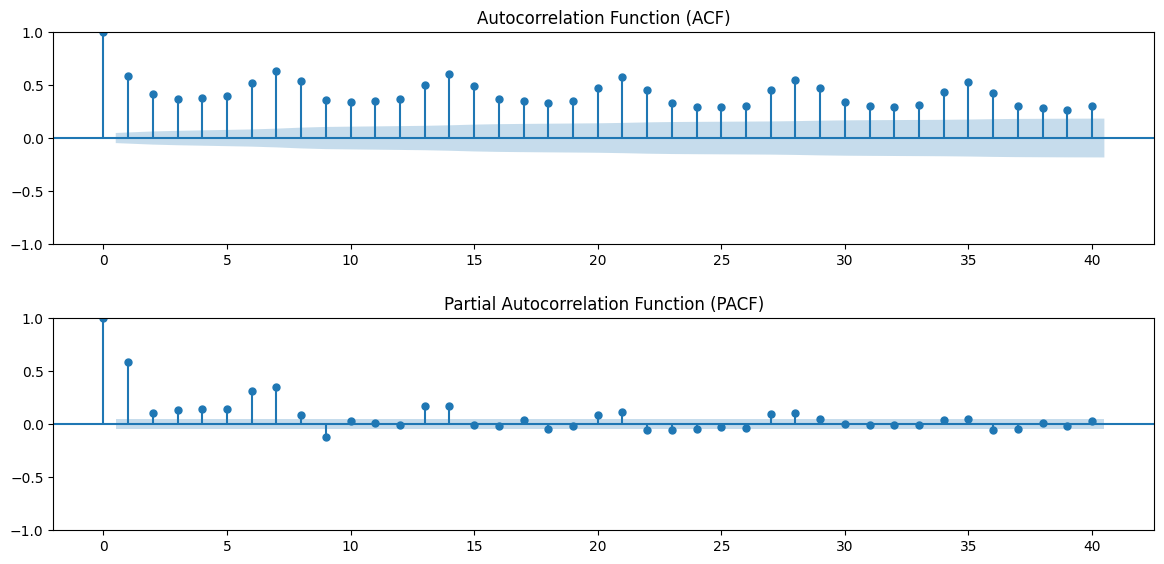

In [146]:
# Get the sales time series data based on the sample
ts = sampled_train.groupby(sampled_train.index)['sales'].sum()

# Create subplots with 2 rows and 1 column, specifying figsize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot the Autocorrelation Function (ACF) on the first subplot (ax1)
sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)")  # Add a title to the first subplot

# Plot the Partial Autocorrelation Function (PACF) on the second subplot (ax2)
sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
ax2.set_title("Partial Autocorrelation Function (PACF)")  # Add a title to the second subplot

# Add padding between the two subplots for better visualization
plt.tight_layout(pad=2.0)

# Display the plots
plt.show()

Both the ACF and PACF start with a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.

The difference between ACF and PACF is the inclusion or exclusion of indirect correlations in the calculation.

Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

In the figures above we can see highly significant lags every 7 time periods. This indicates a 7 time period seasonal cycle in the data. The ACF is gradually declining with every 7th period and the PACF shows a 1 significant seasonal lag(1st). This suggests that the series is a seasonal-AR(1) process because the PACF has 1 significant lag.

Additionally, this series is also an ARMA process because the other lags of both ACF nad PACF are geometrically declining

In [147]:
# Check for linear associations between the variables
correlation_matrix = sampled_train.phik_matrix()


interval columns not set, guessing: ['store_nbr', 'sales', 'onpromotion', 'oil_prices', 'cluster', 'Year', 'Month', 'Day', 'diff']


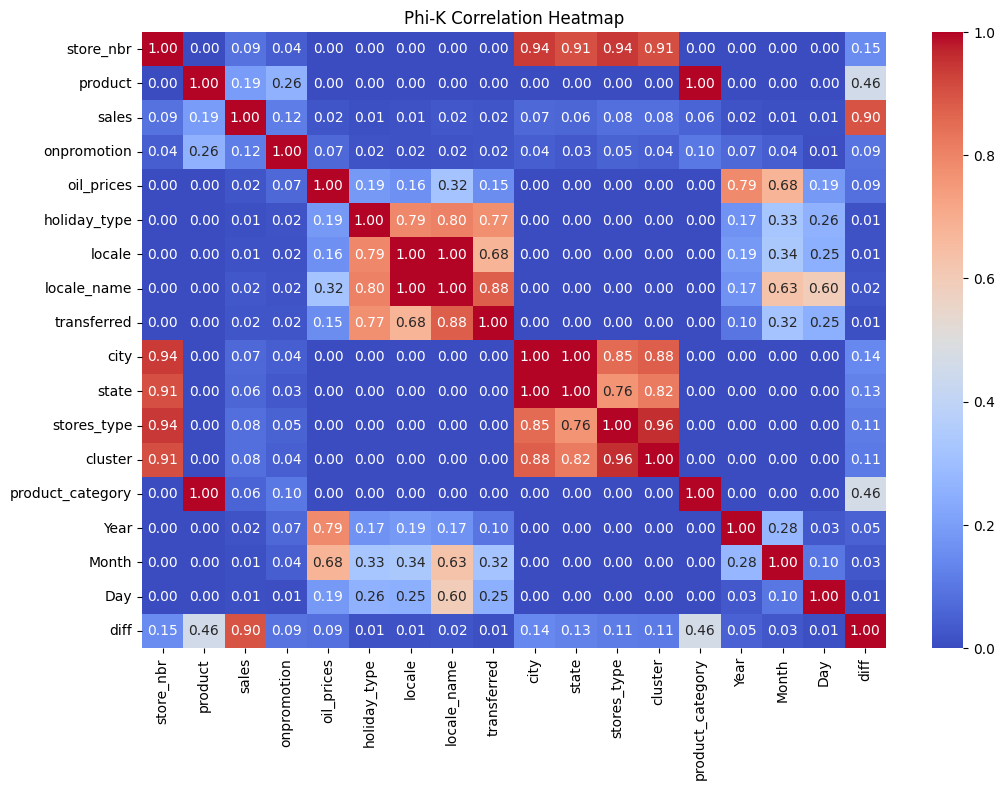

In [148]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8)) # Set the figure size

# Use seaborn to plot the matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")

# Set the plot title
plt.title("Phi-K Correlation Heatmap")

# Show the plot
plt.show()


In [149]:
# performing feature selection
coff=abs(correlation_matrix['sales'])
coff.sort_values(ascending=False)

sales               1.000000
diff                0.898254
product             0.191947
onpromotion         0.115084
store_nbr           0.088891
cluster             0.080175
stores_type         0.080117
city                0.065102
state               0.060588
product_category    0.056413
locale_name         0.024810
oil_prices          0.020081
transferred         0.019664
Year                0.017791
locale              0.013448
Month               0.011697
holiday_type        0.011391
Day                 0.011354
Name: sales, dtype: float64

In [150]:
# since family is more correlated than product_category, we drop the product_category and any other variable not required for training
sampled_train.drop(['product_category','locale_name'], axis=1, inplace= True)
# drop locale_name in test
merged3_test.drop('locale_name', axis=1, inplace=True)

## Feature Encoding
### It involves transforming categorical and textual data into a numerical format that can be fed into statistical models and machine learning algorithms.

In [151]:
sampled_train.columns

Index(['store_nbr', 'product', 'sales', 'onpromotion', 'oil_prices',
       'holiday_type', 'locale', 'transferred', 'city', 'state', 'stores_type',
       'cluster', 'Year', 'Month', 'Day', 'diff'],
      dtype='object')

Encode Train

In [152]:
# Specify the categorical columns to one-hot encode
train_columns = ['product', 'city', 'state', 'stores_type', 'holiday_type','locale','transferred']

# Perform one-hot encoding
encoded_train = pd.get_dummies(sampled_train, columns=train_columns)

# Get a list of columns that were not one-hot encoded
remaining_columns = [col for col in sampled_train.columns if col not in train_columns]

# Add the remaining columns to the encoded_train DataFrame
for col in remaining_columns:
    encoded_train[col] = sampled_train[col]

# Display the updated DataFrame with one-hot encoding and the remaining columns
print(encoded_train)

            store_nbr    sales  onpromotion  oil_prices  cluster  Year  Month  \
date                                                                            
2013-01-01       27.0    0.000          0.0   93.139999        1  2013      1   
2013-01-01       54.0    0.000          0.0   93.139999        3  2013      1   
2013-01-01       35.0    0.000          0.0   93.139999        3  2013      1   
2013-01-01       23.0    0.000          0.0   93.139999        9  2013      1   
2013-01-01       23.0    0.000          0.0   93.139999        9  2013      1   
...               ...      ...          ...         ...      ...   ...    ...   
2017-08-15       46.0    8.000          2.0   47.570000       14  2017      8   
2017-08-15       53.0    0.000          0.0   47.570000       13  2017      8   
2017-08-15       21.0  135.858          0.0   47.570000        6  2017      8   
2017-08-15       42.0   35.000          0.0   47.570000        2  2017      8   
2017-08-15       18.0    1.0

In [153]:
encoded_train.head()

,store_nbr,sales,onpromotion,oil_prices,cluster,Year,Month,Day,diff,product_AUTOMOTIVE,...,holiday_type_No Holiday,holiday_type_Transfer,holiday_type_Work Day,locale_Local,locale_National,locale_No Holiday,locale_Regional,transferred_No,transferred_No Holiday,transferred_Yes
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,27.0,0.0,0.0,93.139999,1,2013,1,1,0.0,False,...,False,False,False,False,True,False,False,True,False,False
2013-01-01,54.0,0.0,0.0,93.139999,3,2013,1,1,0.0,False,...,False,False,False,False,True,False,False,True,False,False
2013-01-01,35.0,0.0,0.0,93.139999,3,2013,1,1,0.0,False,...,False,False,False,False,True,False,False,True,False,False
2013-01-01,23.0,0.0,0.0,93.139999,9,2013,1,1,0.0,False,...,False,False,False,False,True,False,False,True,False,False
2013-01-01,23.0,0.0,0.0,93.139999,9,2013,1,1,0.0,False,...,False,False,False,False,True,False,False,True,False,False


Encoding test

In [154]:
merged3_test.columns

Index(['id', 'store_nbr', 'product', 'onpromotion', 'oil_prices',
       'holiday_type', 'locale', 'transferred', 'city', 'state', 'stores_type',
       'cluster', 'Year', 'Month', 'Day'],
      dtype='object')

In [155]:
# drop id column
merged3_test.drop('id', axis=1, inplace=True)

In [156]:
# Specify the categorical columns to one-hot encode
test_columns = ['product', 'city', 'state', 'stores_type', 'holiday_type','locale','transferred']

# Perform one-hot encoding
encoded_test = pd.get_dummies(merged3_test, columns=test_columns)

# Get a list of columns that were not one-hot encoded
remaining_columns = [col for col in merged3_test.columns if col not in test_columns]

# Add the remaining columns to the encoded_train DataFrame
for col in remaining_columns:
    encoded_test[col] = merged3_test[col]

# Display the updated DataFrame with one-hot encoding and the remaining columns
print(encoded_test.head())

            store_nbr  onpromotion  oil_prices  cluster  Year  Month  Day  \
date                                                                        
2017-08-16          1            0   46.799999       13  2017      8   16   
2017-08-16          1            0   46.799999       13  2017      8   16   
2017-08-16          1            2   46.799999       13  2017      8   16   
2017-08-16          1           20   46.799999       13  2017      8   16   
2017-08-16          1            0   46.799999       13  2017      8   16   

            product_AUTOMOTIVE  product_BABY CARE  product_BEAUTY  ...  \
date                                                               ...   
2017-08-16                True              False           False  ...   
2017-08-16               False               True           False  ...   
2017-08-16               False              False            True  ...   
2017-08-16               False              False           False  ...   
2017-08-16      

In [157]:
encoded_test.head()

,store_nbr,onpromotion,oil_prices,cluster,Year,Month,Day,product_AUTOMOTIVE,product_BABY CARE,product_BEAUTY,...,stores_type_B,stores_type_C,stores_type_D,stores_type_E,holiday_type_Holiday,holiday_type_No Holiday,locale_Local,locale_No Holiday,transferred_No,transferred_No Holiday
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,0,46.799999,13,2017,8,16,True,False,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,0,46.799999,13,2017,8,16,False,True,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,2,46.799999,13,2017,8,16,False,False,True,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,20,46.799999,13,2017,8,16,False,False,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,0,46.799999,13,2017,8,16,False,False,False,...,False,False,True,False,False,True,False,True,False,True


In [158]:
encoded_test.dtypes

store_nbr                    int64
onpromotion                  int64
oil_prices                 float64
cluster                      int64
Year                         int32
                            ...   
holiday_type_No Holiday       bool
locale_Local                  bool
locale_No Holiday             bool
transferred_No                bool
transferred_No Holiday        bool
Length: 89, dtype: object

In [159]:
encoded_train.dtypes

store_nbr                 float64
sales                     float64
onpromotion               float64
oil_prices                float64
cluster                     int64
                           ...   
locale_No Holiday            bool
locale_Regional              bool
transferred_No               bool
transferred_No Holiday       bool
transferred_Yes              bool
Length: 99, dtype: object

In [160]:
# convert float to integer
encoded_train['store_nbr'] = encoded_train['store_nbr'].astype(int)
encoded_train['onpromotion'] = encoded_train['onpromotion'].astype(int)

In [161]:
# Convert int64 to int32 due to memory capacity
encoded_train['cluster'] = encoded_train['cluster'].astype('int32')
encoded_test['cluster'] = encoded_test['cluster'].astype('int32')
encoded_test['store_nbr'] = encoded_test['store_nbr'].astype('int32')
encoded_test['onpromotion'] = encoded_test['onpromotion'].astype('int32')
# Convert float64 to float32
encoded_train['sales'] = encoded_train['sales'].astype('float32')
encoded_train['oil_prices'] = encoded_train['oil_prices'].astype('float32')
encoded_test['oil_prices'] = encoded_test['oil_prices'].astype('float32')

In [162]:
# drop the sales columns as we have now differenced the sales
encoded_train.drop('sales', axis=1, inplace= True)

In [163]:
# rename 'diff' to 'diff_sales'
encoded_train.rename(columns={'diff': 'diff_sales'}, inplace=True)

### normalizing the 'sales' column

In [164]:
# calculates the minimum value in the 'sales' column
# then subtracts the minimum value found in step 1 from every value in the 'sales' column and then adds 1 to each of these values.
encoded_train['diff_sales'] = encoded_train['diff_sales'] - encoded_train['diff_sales'].min() + 1

 By subtracting the minimum value and adding 1, we ensure that the minimum value in the 'sales' column is 1. This is useful as we are working with certain models or algorithms that require positive input values.The addition of 1 is like adding a constant offset to all values. It doesn't change the relative differences between values.

### Modelling

In [165]:
encoded_train.shape

(1221740, 98)

In [166]:
## splitting data to train and evalution
train_data = encoded_train[:1000000]
eval = encoded_train[1000000:]

In [167]:
# Training data 
y_train=train_data["diff_sales"]
X_train = train_data.drop(columns = ["diff_sales"])

# evaluating data 
y_eval = eval["diff_sales"]
X_eval = eval.drop(columns = ["diff_sales"])

In [168]:
y_train.shape

(1000000,)

## Model Training
### here we create instances of different models (Random Forest and Decision Tree Regressors) and add them to the models dictionary. Then, we loop through each model, train it on the training data, evaluate it on the evaluation data, and print their evaluation metrics, which include MSE, RMSE and RMSLE.


In [165]:
# Create an instance of the RandomForestRegressor
rf= RandomForestRegressor(random_state=42) 
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_eval)
mse= mean_squared_error(y_eval, rf_pred)
rmse= mse**.05
rmsle= np.sqrt(mean_squared_log_error(y_eval, rf_pred))
print(mse)
print(rmse)
print(rmsle)

 

2405787.375977458
2.084792625182224
0.017873265767819488


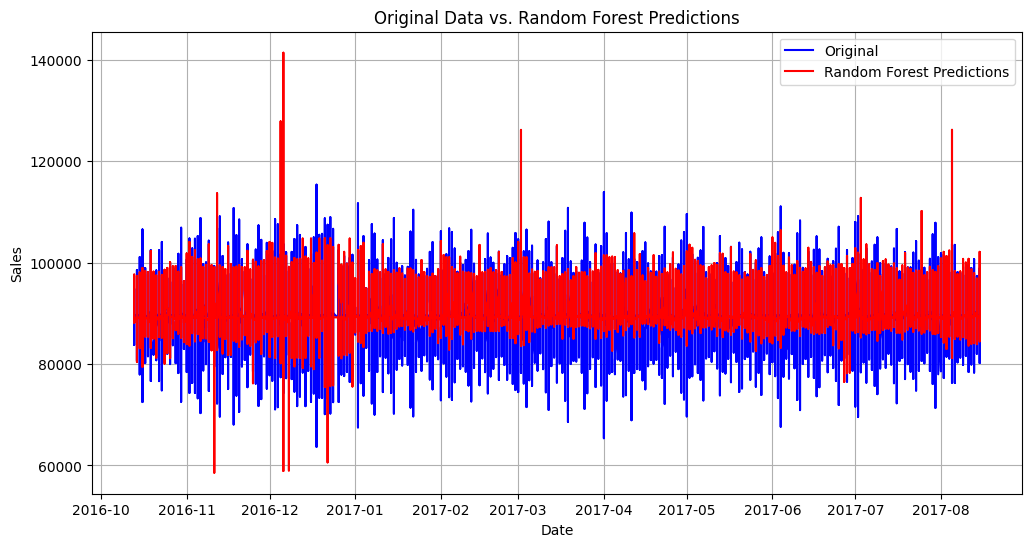

In [166]:
# plot predictions
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(y_eval.index, y_eval.values, label='Original', color='blue')

# Plot the Random Forest predictions
plt.plot(y_eval.index, rf_pred, label='Random Forest Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. Random Forest Predictions')
plt.legend()
plt.grid(True)

plt.show()

The model's predictions are very close to the actual values, and the fit is nearly perfect. The red line (predicted values) follows the blue line (actual values) throughout the entire time series. The low RMSLE 0f 0.017 suggests that the Random Forest model has effectively captured the underlying patterns, seasonality, and trends in the sales data. It means that the model's predictions are not only close to the actual values but also in the same relative proportion as the original data.

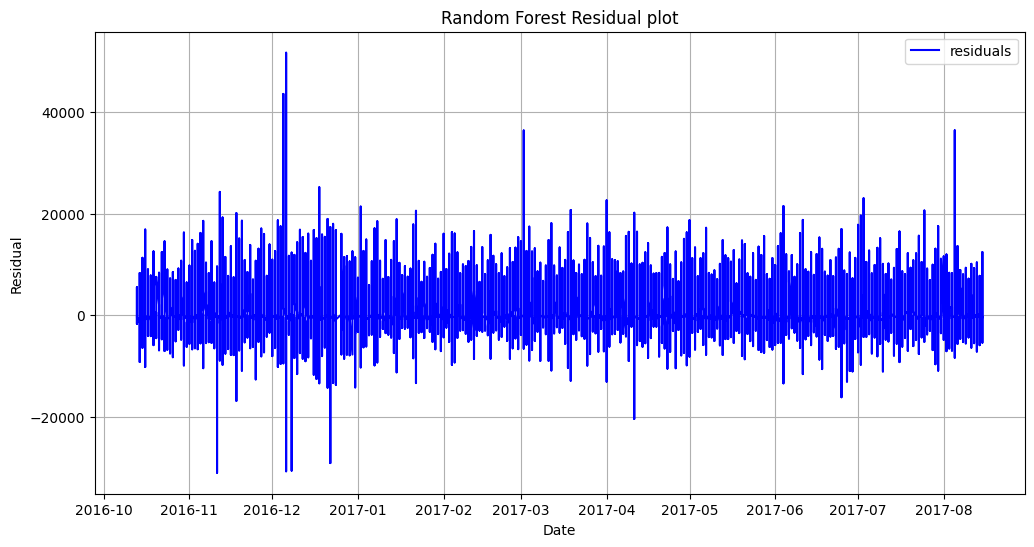

In [198]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(y_eval.index, (rf_pred - y_eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Random Forest Residual plot')
plt.legend()
plt.grid(True)
plt.show()

The residuals are centered around the zero line on the vertical axis. the residuals have a mean close to zero, indicating that, on average, the model neither overpredicts nor underpredicts. There is a random scatter of points around the horizontal axis. This suggests that the model is capturing the underlying data patterns well.

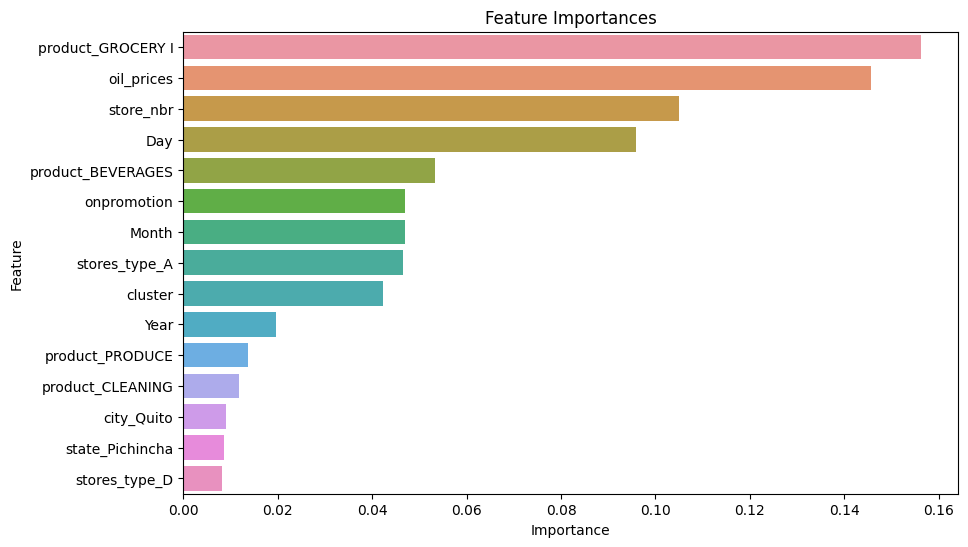

In [168]:
rf_importance=rf.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph shows the contribution of each input variable (feature) in predicting the target variable or sales. Above features are the top 15 features that are most influential in making predictions, with grocery 1, oil prices, store number, day of the year and bevarages being the top contributors in predicting sales using the random forest model.

### Decision Tree Regressor

In [169]:
# Create an instance of the Decision Trees
dt= DecisionTreeRegressor(random_state=42) 
dt.fit(X_train,y_train)
dt_pred=dt.predict(X_eval)
mse= mean_squared_error(y_eval, dt_pred)
rmse= mse**.05
rmsle= np.sqrt(mean_squared_log_error(y_eval, dt_pred))
print(mse)
print(rmse)
print(rmsle)

5406462.153521322
2.170929191084876
0.11403589289722584


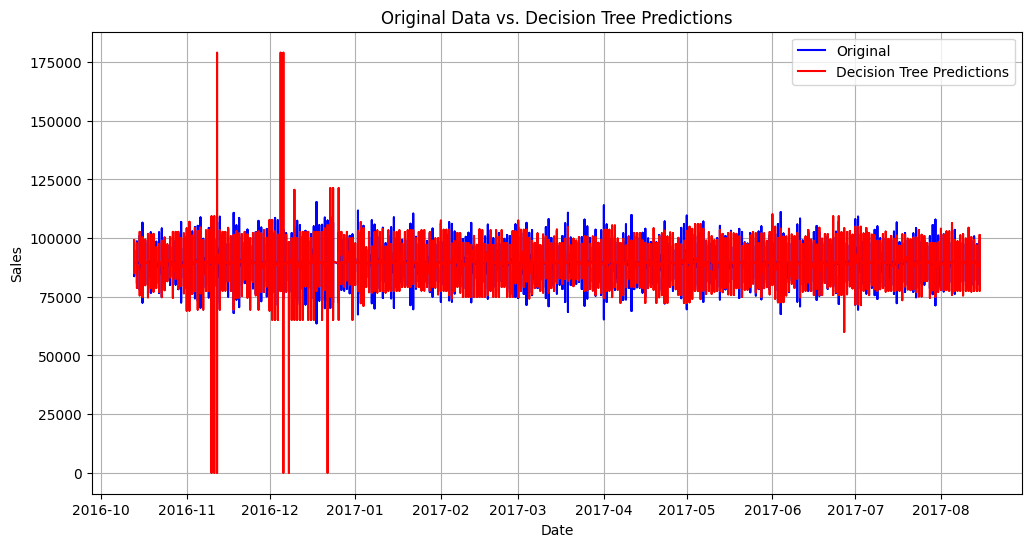

In [170]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(y_eval.index, y_eval.values, label='Original', color='blue')

# Plot the Decision Trees predictions
plt.plot(y_eval.index, dt_pred, label='Decision Tree Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. Decision Tree Predictions')
plt.legend()
plt.grid(True)

plt.show()

The Decision Trees model produces predictions with an RMSLE (Root Mean Squared Logarithmic Error) of 0.11, it indicates that the model's predictions are quite close to the actual values, although not as precise as the Random Forest model with an RMSLE of 0.017. while the fit is close, there are some instances where the predictions deviate slightly from the actual values.generally, the Decision Trees model has captured most of the important trends, seasonality, and variations in the data. However, there may be some occasional deviations from the true values.

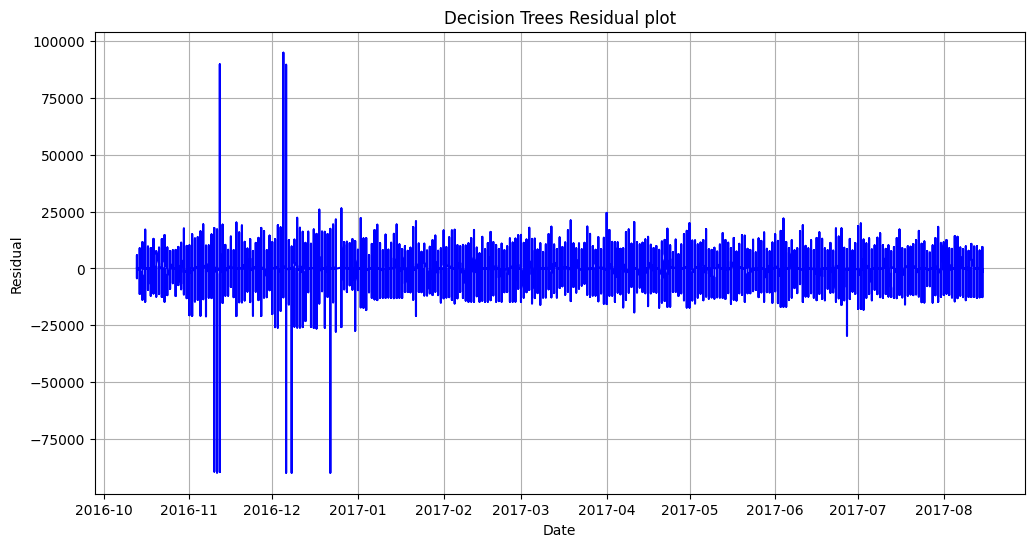

In [199]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(y_eval.index, (dt_pred - y_eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('Decision Trees Residual plot')
plt.grid(True)

plt.show()

we can observe that the residuals are centered around the zero line on the vertical axis. Ideally, the residuals should have a mean close to zero, indicating that, on average, the model neither overpredicts nor underpredicts. Also the random scatter of points around the horizontal axis suggests that the model is capturing the underlying data patterns well.

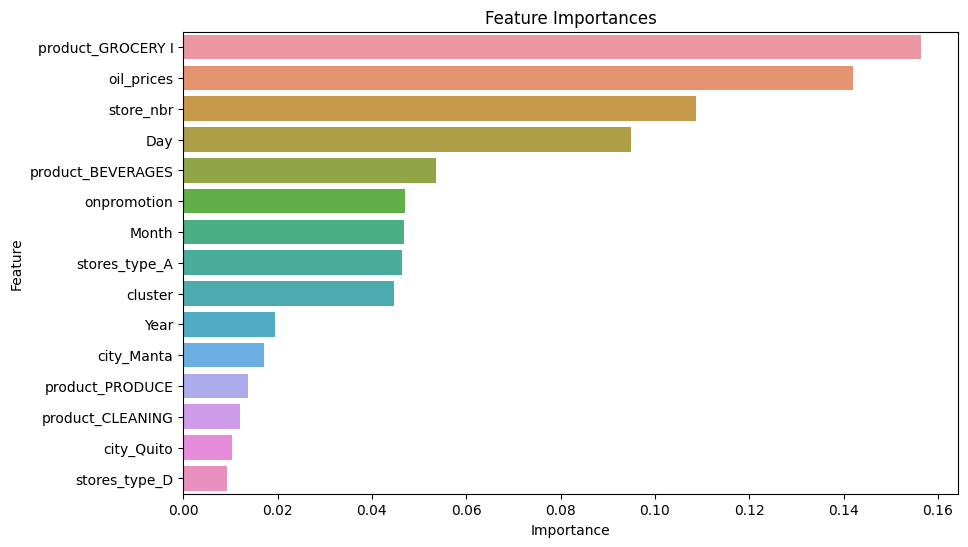

In [172]:
dt_importance=dt.feature_importances_
# Create a DataFrame to store feature names and their importances
feature_importance_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': dt_importance})

# Sort the DataFrame by importance
feature_importance_dt = feature_importance_dt.sort_values(by='Importance', ascending=False).head(15)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_dt)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

The graph shows the contribution of each input variable (feature) in predicting the target variable or sales. Above features are the top 15 features that are most influential in making predictions, with grocery 1, oil prices, store number, day of the year and bevarages also ranking as the top contributors in predicting sales using Decision tree model.

## Statistical Models

In [173]:
# group the data by date and average sales for stat models
data = train_data.groupby(train_data.index)['diff_sales'].sum().reset_index()
eval = eval.groupby(eval.index)['diff_sales'].sum().reset_index()

In [174]:
# setting first name as index column
data.set_index('date', inplace=True)
eval.set_index('date', inplace=True)

In [175]:
data.head()

,diff_sales
date,
2013-01-01,67493073.44
2013-01-02,62659355.00
2013-01-03,66866477.92
2013-01-04,63196571.89
2013-01-05,63824989.95


In [176]:
model= AutoReg(data, lags=1).fit()

In [177]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:             diff_sales   No. Observations:                 1380
Model:                     AutoReg(1)   Log Likelihood              -24259.274
Method:               Conditional MLE   S.D. of innovations       10564323.571
Date:                Sun, 17 Sep 2023   AIC                          48524.548
Time:                        09:39:06   BIC                          48540.235
Sample:                             1   HQIC                         48530.416
                                 1380                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           6.49e+07   1.77e+06     36.664      0.000    6.14e+07    6.84e+07
diff_sales.L1    -0.0005      0.027     -0.019      0.985      -0.053       0.052
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1        -1946.0553           +0.0000j         1946.0553            0.5000
-----------------------------------------------------------------------------
"""

In [178]:
# make predictions on eval data
AR_pred=model.predict(start=len(data),
                      end=len(data)+len(eval)-1,
                      dynamic = False
                      )

In [179]:
# evaluate our models
mse= mean_squared_error(eval, AR_pred)
msle=mean_squared_log_error(eval, AR_pred)
rmse= np.sqrt(mean_squared_error(eval, AR_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, AR_pred)).round(2)

results=pd.DataFrame([['AR',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,AR,1.198563e+14,0.027674,10947890.77,0.17


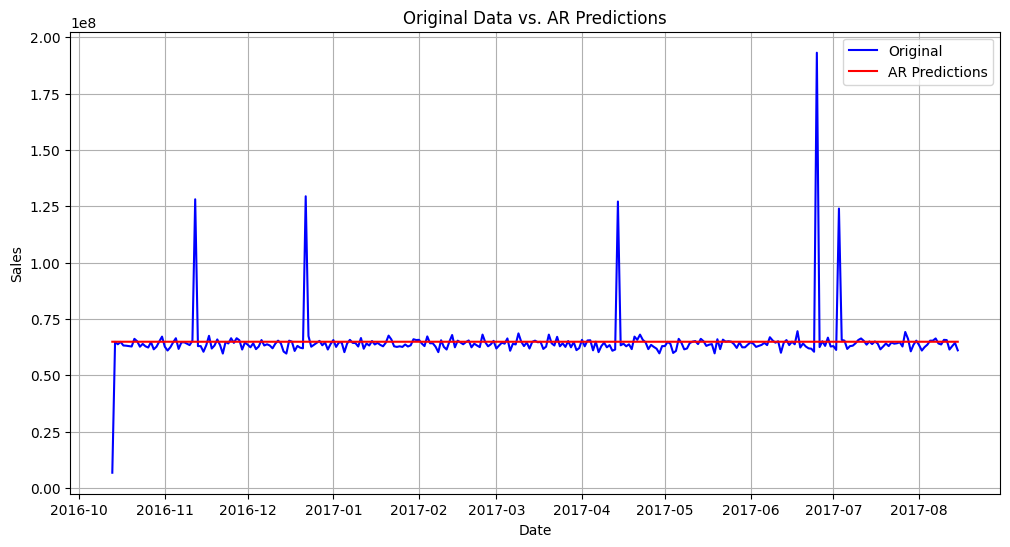

In [180]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the AR predictions
plt.plot(eval.index, AR_pred, label='AR Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. AR Predictions')
plt.legend()
plt.grid(True)

plt.show()

The RMSLE value of 0.17 means that, on average, the model's predictions have a relatively low logarithmic error compared to the actual values. It suggests that the model is making predictions that are reasonably close to the true values, with a relatively small amount of error as shown in the visualization

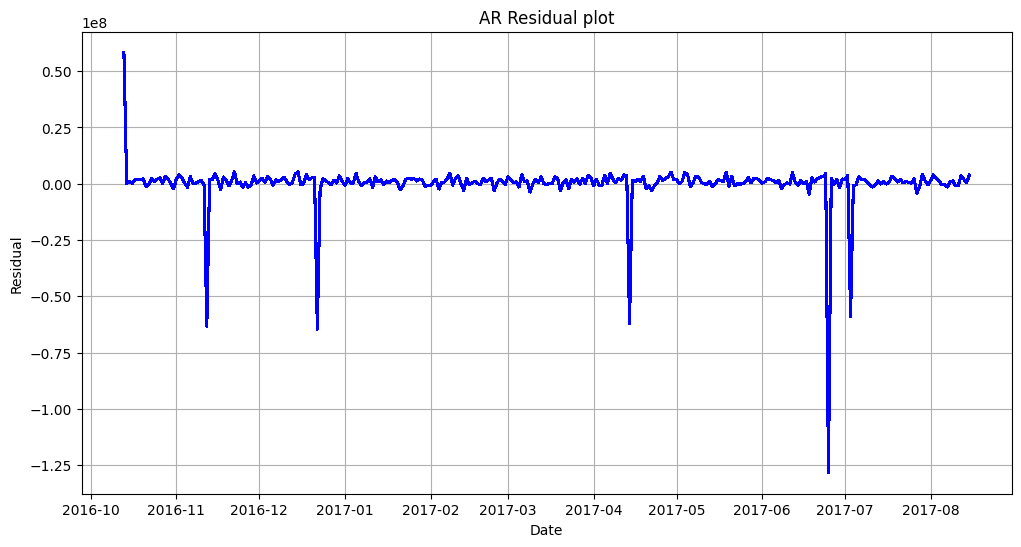

In [200]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (AR_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('AR Residual plot')
plt.grid(True)
plt.show()

 A residual plot helps identify whether the AR model captures the temporal dependencies in the data effectively. we can see that residuals are distributed relatively evenly around zero, with no apparent patterns or trends.Points above the zero line represent cases where the model underestimates the actual values. In other words, the observed values are higher than what the model predicted. Points below the zero line represent cases where the model overestimates the actual values. The observed values are lower than the model's predictions.This suggest that the model may need improvement.

## SARIMA MODEL

An SARIMA (Seasonal AutoRegressive Integrated Moving Average) model is a time series forecasting model that captures both autoregressive (AR), differencing (I), and moving average (MA) components, along with seasonality. 

In [182]:
# Define the SARIMA model parameters
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order
P = 1  # Seasonal AR order
D = 1  # Seasonal differencing order
Q = 1  # Seasonal MA order
s = 12  # Seasonal period (e.g., 12 for monthly data)

# Create the SARIMA model
sarima_model = sm.tsa.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit= sarima_model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         diff_sales   No. Observations:                 1380
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -24346.248
Date:                            Sun, 17 Sep 2023   AIC                          48702.496
Time:                                    09:39:12   BIC                          48728.598
Sample:                                         0   HQIC                         48712.265
                                           - 1380                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0109      0.043     -0.255      0.798      -0.094       0.073
ma.L1         -0.8569      0.033    -25.892      0.000      -0.922      -0.792
ar.S.L12      -0.0438      0.072     -0.611      0.541      -0.185       0.097
ma.S.L12      -0.9538      0.028    -34.611      0.000      -1.008      -0.900
sigma2      2.992e+14   1.57e-16   1.91e+30      0.000    2.99e+14    2.99e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):            565275.52
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             7.81
Prob(H) (two-sided):                  0.03   Kurtosis:                       101.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [183]:
# make predictions on the eval data
SARIMA_pred=model_fit.predict(start=len(data),
                      end=len(data)+len(eval)-1,
                      type = 'levels'
                      )

In [184]:
# evaluate our models
mse= mean_squared_error(eval, SARIMA_pred)
msle=mean_squared_log_error(eval, SARIMA_pred)
rmse= np.sqrt(mean_squared_error(eval, SARIMA_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, SARIMA_pred)).round(2)

results=pd.DataFrame([['SARIMA',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,SARIMA,1.359415e+14,0.030457,11659394.63,0.17


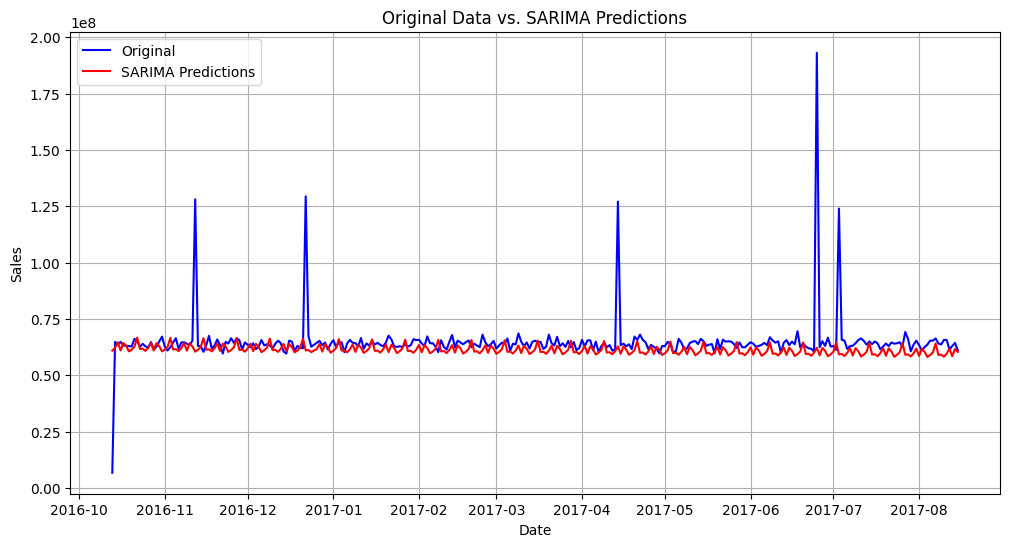

In [185]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the SARIMA predictions
plt.plot(eval.index, SARIMA_pred, label='SARIMA Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. SARIMA Predictions')
plt.legend()
plt.grid(True)

plt.show()

The RMSLE value of 0.17 means that, on average, the SARIMA model's predictions have a relatively low logarithmic error compared to the actual values. It suggests that the SARIMA model is making predictions that are reasonably close to the true values, with a moderate amount of error. From the visualization, we can see that the predicticed sales are slightly deviating from the actual values. This implies that there is need to improve the model.

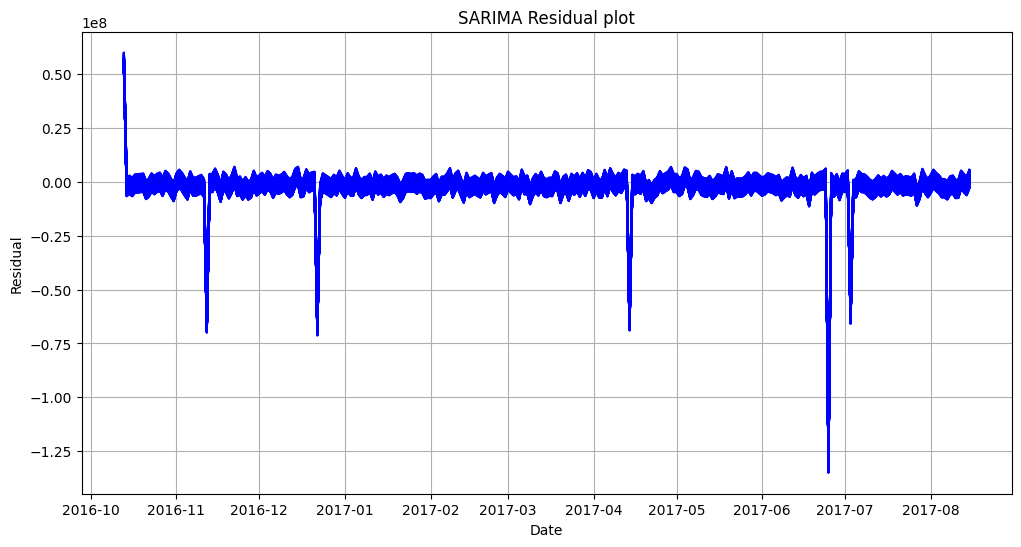

In [201]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (SARIMA_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('SARIMA Residual plot')
plt.grid(True)
plt.show()

we can see that residuals are distributed relatively evenly around zero, with no apparent patterns or trends.Points above the zero line represent cases where the model underestimates the actual values while points below the zero line represent cases where the model overestimates the actual values.Generally, the randomness of residuals and its even ditribution around zero suggests that the SARIMA model is a good fit for the data, and the RMSLE of 0.17 is reflective of a well-performing model.

### ARIMA MODEL

In [187]:
# Get the sales time series data based on the sample
data_sales = encoded_train.groupby(encoded_train.index)['diff_sales'].sum()


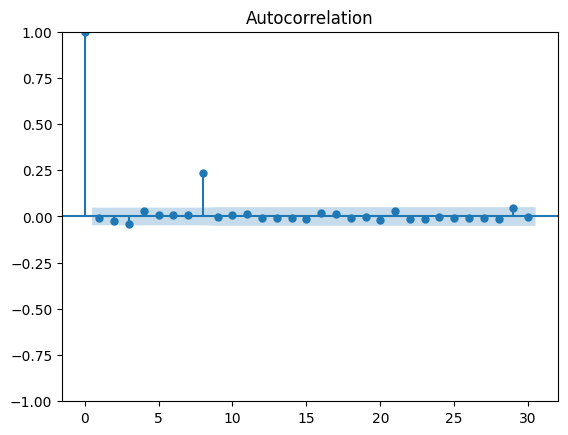

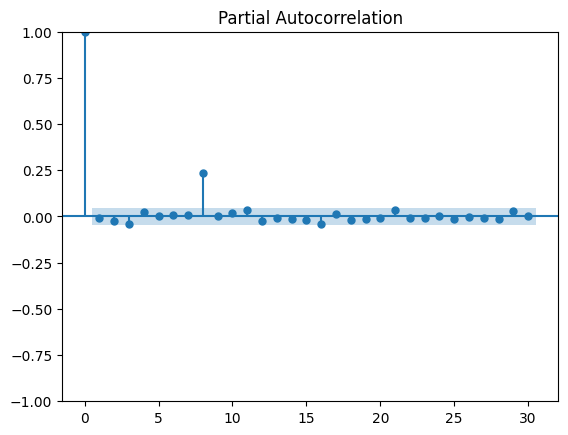

In [188]:
# Determine the order of the ARIMA model (p, d, q) based on ACF and PACF plots
# Plot ACF and PACF
plot_acf(data_sales, lags=30)
plot_pacf(data_sales, lags=30)
plt.show()



Identifying d (Differencing Order):

If the ACF plot shows a slow decay and remains significant at higher lags, your data may need differencing (d) to become stationary.
Check the number of differences required to achieve stationarity. This is typically the number of times you need to difference the data until it becomes stationary. Use the ADF (Augmented Dickey-Fuller) test for stationarity.

Identifying p (AR Order):

For the PACF plot, look for significant spikes at lags before they drop off to insignificance. These spikes indicate the order of the autoregressive (AR) component (p).
If the PACF plot cuts off after p lags, this suggests that the AR term should be set to p. In other words, p is the lag value where the PACF sharply drops to zero.

Identifying q (MA Order):

For the ACF plot, look for significant spikes at lags before they drop off to insignificance. These spikes indicate the order of the moving average (MA) component (q).
If the ACF plot cuts off after q lags, this suggests that the MA term should be set to q. In other words, q is the lag value where the ACF sharply drops to zero.

we used a one order difference to make the data stationary, hence d=1                                                                 
both ACF and PACF sharply drops to zero at lag 9


In [189]:

# Based on the plots, choose the order (p, d, q)
p, d, q = (9, 1, 9)  

# Build and train the ARIMA model
model = ARIMA(data, order=(p, d, q))
results = model.fit()

In [190]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             diff_sales   No. Observations:                 1380
Model:                 ARIMA(9, 1, 9)   Log Likelihood              -24231.226
Date:                Sun, 17 Sep 2023   AIC                          48500.451
Time:                        09:39:30   BIC                          48599.804
Sample:                             0   HQIC                         48537.619
                               - 1380                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8569      0.483     -1.775      0.076      -1.803       0.089
ar.L2         -0.1503      0.356     -0.422      0.673      -0.848       0.548
ar.L3          0.0265      0.235      0.113      0.910      -0.434       0.487
ar.L4         -0.0119      0.208     -0.057      0.954      -0.420       0.396
ar.L5         -0.2616      0.249     -1.051      0.293      -0.749       0.226
ar.L6         -0.4092      0.308     -1.331      0.183      -1.012       0.194
ar.L7         -0.3063      0.317     -0.966      0.334      -0.928       0.315
ar.L8         -0.0454      0.274     -0.166      0.868      -0.583       0.493
ar.L9          0.1361      0.088      1.538      0.124      -0.037       0.310
ma.L1         -0.1314      0.479     -0.275      0.784      -1.069       0.807
ma.L2         -0.7273      0.396     -1.838      0.066      -1.503       0.048
ma.L3         -0.2373      0.367     -0.647      0.517      -0.956       0.481
ma.L4          0.0871      0.321      0.271      0.786      -0.542       0.716
ma.L5          0.3160      0.265      1.192      0.233      -0.204       0.836
ma.L6          0.1505      0.307      0.489      0.624      -0.452       0.753
ma.L7         -0.1272      0.387     -0.329      0.742      -0.886       0.631
ma.L8         -0.0726      0.228     -0.318      0.751      -0.520       0.375
ma.L9         -0.2383      0.278     -0.856      0.392      -0.784       0.307
sigma2      1.112e+14    2.8e-13   3.98e+26      0.000    1.11e+14    1.11e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1109656.97
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            10.07
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.15e+41. Standard errors may be unstable.
"""

In [191]:
# make predictions on the eval data
ARIMA_pred=results.predict(start=len(data),
                      end=len(data)+len(eval)-1,
                      type = 'levels'
                      )

In [192]:
# evaluate our models
mse= mean_squared_error(eval, ARIMA_pred)
msle=mean_squared_log_error(eval, ARIMA_pred)
rmse= np.sqrt(mean_squared_error(eval, ARIMA_pred)).round(2)
rmsle= np.sqrt(mean_squared_log_error(eval, ARIMA_pred)).round(2)

results=pd.DataFrame([['ARIMA',mse, msle, rmse, rmsle]], columns= ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

,Model,MSE,MSLE,RMSE,RMSLE
0,ARIMA,1.203230e+14,0.02804,10969185.69,0.17


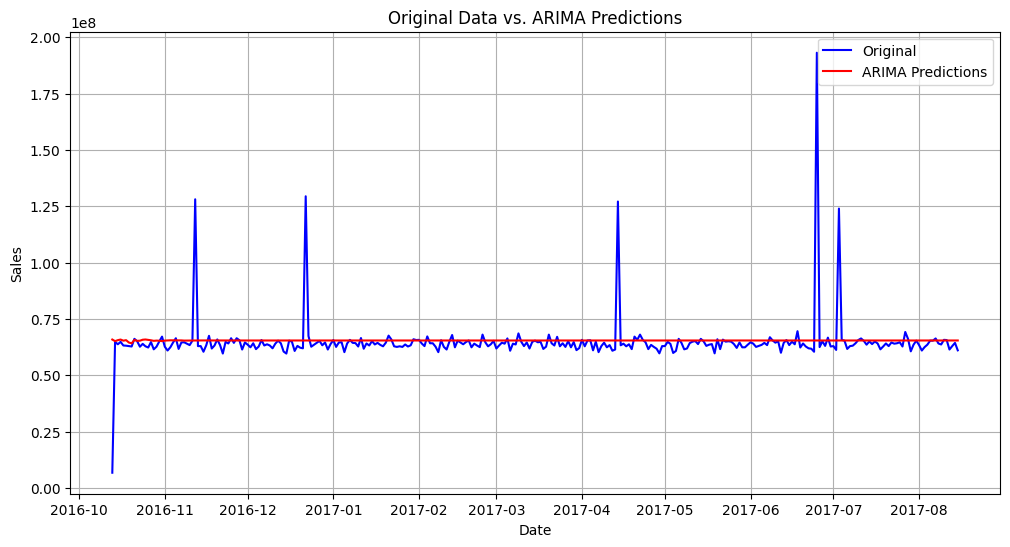

In [193]:
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the original data
plt.plot(eval.index, eval.values, label='Original', color='blue')

# Plot the ARIMA predictions
plt.plot(eval.index, ARIMA_pred, label='ARIMA Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Original Data vs. ARIMA Predictions')
plt.legend()
plt.grid(True)

plt.show()

 The ARIMA model is providing predictions that are reasonably close to the actual values. An RMSLE of 0.17 indicates that the model's predictions are on average within a relatively small percentage error of the actual values. An RMSLE of 0.17 means that the model's predictions deviate from the actual values by around 17% on average when considering the logarithm of the values. Hence, there is need to refine the model to improve the RMSLE.

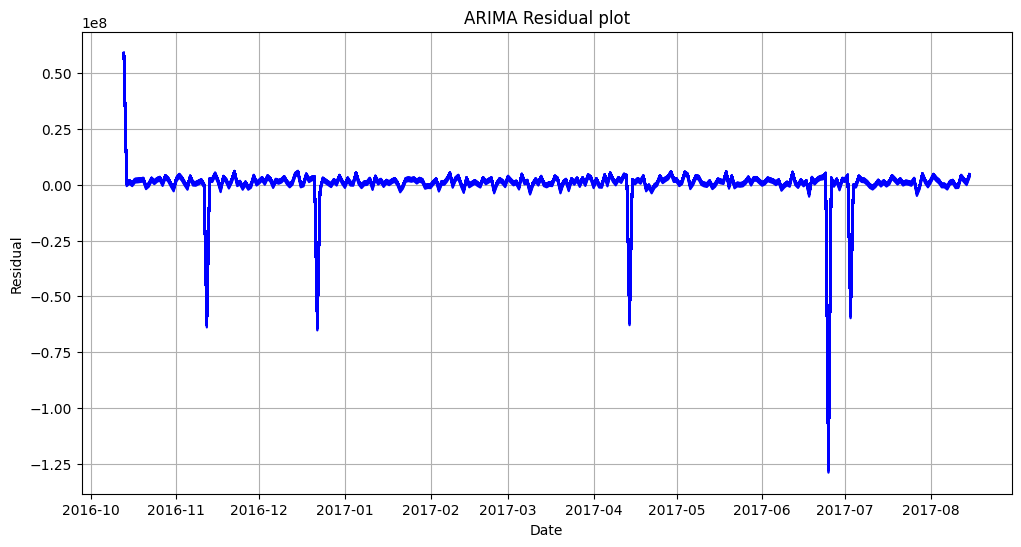

In [202]:
# plot the residual plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the residual data
plt.plot(eval.index, (ARIMA_pred.values - eval.values), label='residuals', color='blue')

plt.xlabel('Date')
plt.ylabel('Residual')
plt.title('ARIMA Residual plot')
plt.grid(True)
plt.show()

The residuals are centered around zero. This means that, on average, the model is not systematically overestimating or underestimating the target variable.  The randomness of residuals indicates that the model has captured most of the underlying patterns in the data.This suggests that the ARIMA model is a good fit for the data, and the RMSLE of 0.17 is reflective of a well-performing model.

### Model Comparison

In [210]:

# Create an empty list to store the results
results_list = []

# Model 1 results
model1_results = ['ARIMA', 1.203230e+14, 0.02804, 10969185.69, 0.17]
results_list.append(model1_results)

# Model 2 results
model2_results = ['SARIMA', 1.359415e+14, 0.030457, 11659394.63, 0.17]
results_list.append(model2_results)

# Model 3 results
model3_results = ['Decision Trees', 5406462.15, '' , 2.1709, 0.11]
results_list.append(model3_results)

# Model 4 results
model4_results = ['Random Forest', 2405787.38,'', 2.0848, 0.02]
results_list.append(model4_results)

# Model 5 results
model5_results = ['AR', 1.198563e+14, 0.027674, 10947890.77, 0.17]
results_list.append(model5_results)

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list, columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

# Print the combined results
print(results_df)


            Model           MSE      MSLE          RMSE  RMSLE
0           ARIMA  1.203230e+14   0.02804  1.096919e+07   0.17
1          SARIMA  1.359415e+14  0.030457  1.165939e+07   0.17
2  Decision Trees  5.406462e+06            2.170900e+00   0.11
3   Random Forest  2.405787e+06            2.084800e+00   0.02
4              AR  1.198563e+14  0.027674  1.094789e+07   0.17


 From the results of the models trained, Random Forest is the best performing model with an RMSLE of 0.02. Root Mean Squared Logarithmic Error (RMSLE) is a metric commonly used to evaluate the performance of regression models, especially in cases where the target variable has a wide range of values and is subject to exponential growth or decay. RMSLE measures the accuracy of predictions on a logarithmic scale, making it suitable for tasks where relative errors are more important than absolute errors. Thus looking at the results, the performance of stat models is slightly lower compared to machine learning models. Hence, we fine tune the parameters of stat models to improve their performance.

### Hyperparameter tuning

Tuning ARIMA Model

In [206]:
# Define a parameter grid
param_grid = {
    'order': [(0, 1, 1), (1, 1, 1), (1, 1, 2), (2, 1, 1), (2, 1, 2)],
}

best_rmsle = 0.17
best_model = None

# Perform grid search
for params in param_grid['order']:
    model = ARIMA(data, order=params)
    A_model=model.fit()

    # Use 'forecast' to predict future values
    forecast = A_model.forecast(steps=len(eval))

    # extract the point forecasts
    y_pred = forecast

    # Evaluate your predictions
    mse = mean_squared_error(eval, y_pred)
    msle=mean_squared_log_error(eval, y_pred)
    rmse= np.sqrt(mean_squared_error(eval, y_pred)).round(2)
    rmsle= np.sqrt(mean_squared_log_error(eval, y_pred)).round(2)
    if rmsle < best_rmsle:
        best_rmsle = rmsle
        best_model = model

# The best model and hyperparameters
print(f"Best_rmsle: {best_rmsle}")
print(f"Best Hyperparameters: {params}")


Best_rmsle: 0.17
Best Hyperparameters: (2, 1, 2)


we are still getting a best RMSLE of 0.16 with an order of (2,1,2)

Tuning SARIMA Model

In [207]:

# Define parameter grid
param_grid = {
    'p': [1,2],
    'd': [1],
    'q': [1,2],
    'P': [1,2],
    'D': [1],
    'Q': [1,2],
    's': [12]  # Seasonal period (e.g., 12 for monthly data)
}

best_rmsle = 0.17
best_params = None

for params in ParameterGrid(param_grid):
    # Fit SARIMA model with current hyperparameters
    model = SARIMAX(data, order=(params['p'], params['d'], params['q']),
                    seasonal_order=(params['P'], params['D'], params['Q'], params['s']))
    results = model.fit()

    # Make predictions on validation data
    SA_pred=results.predict(start=len(data),
                      end=len(data)+len(eval)-1,
                      type = 'levels'
                      )

    # Calculate RMSE (or another evaluation metric) for validation
    mse = mean_squared_error(eval, SA_pred)
    msle=mean_squared_log_error(eval, SA_pred)
    rmse= np.sqrt(mean_squared_error(eval, SA_pred)).round(2)
    rmsle= np.sqrt(mean_squared_log_error(eval, SA_pred)).round(2)

    # Check if the current RMSE is better than the best RMSE found so far
    if rmsle < best_rmsle:
        best_rmsle = rmsle
        best_params = params

print("Best hyperparameters:", best_params)
print("Best RMSLE:", best_rmsle)


Best hyperparameters: None
Best RMSLE: 0.17


after tuning the SARIMA model the best RMSLE is still 0.17 with best hyperparameters including {'D': 1, 'P': 1, 'Q': 1, 'd': 1, 'p': 1, 'q': 1, 's': 12}

In [211]:
results_df

,Model,MSE,MSLE,RMSE,RMSLE
0,ARIMA,1.203230e+14,0.02804,1.096919e+07,0.17
1,SARIMA,1.359415e+14,0.030457,1.165939e+07,0.17
2,Decision Trees,5.406462e+06,,2.170900e+00,0.11
3,Random Forest,2.405787e+06,,2.084800e+00,0.02
4,AR,1.198563e+14,0.027674,1.094789e+07,0.17


The RMSLE is a measure of accuracy that considers the logarithm of the actual and predicted values. In this case, the predictions are likely on a logarithmic scale. Therefore, an RMSLE of 0.02 means that the model's predictions deviate from the actual values by around 2% on average when considering the logarithm of the values. Hence, this makes the Random Forest model the best model for predicting sales of the retail store.

### Saving the model

### Pickle is the standard way of serializing objects in Python. we will use the pickle operation to serialize our machine learning algorithm and save the serialized format to a file

In [213]:
# saving our best model
sales_pred_model = RandomForestRegressor(random_state=42)

# Save the model to a file using pickle
with open('sales_pred_model.pkl', 'wb') as model_file:
    pickle.dump(sales_pred_model, model_file)

In [214]:
# Load the model from the saved file
with open('sales_pred_model.pkl', 'rb') as model_file:
    loaded_sales_model = pickle.load(model_file)

# Now we can use loaded_sales_model for predictions and evaluation

In [ ]:
# fit the model on the train data
model = loaded_sales_model.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = model.predict(encoded_test)

test_predictions

### Test Data prediction

In [209]:
encoded_test.head()

,store_nbr,onpromotion,oil_prices,cluster,Year,Month,Day,product_AUTOMOTIVE,product_BABY CARE,product_BEAUTY,...,stores_type_B,stores_type_C,stores_type_D,stores_type_E,holiday_type_Holiday,holiday_type_No Holiday,locale_Local,locale_No Holiday,transferred_No,transferred_No Holiday
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1,0,46.799999,13,2017,8,16,True,False,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,0,46.799999,13,2017,8,16,False,True,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,2,46.799999,13,2017,8,16,False,False,True,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,20,46.799999,13,2017,8,16,False,False,False,...,False,False,True,False,False,True,False,True,False,True
2017-08-16,1,0,46.799999,13,2017,8,16,False,False,False,...,False,False,True,False,False,True,False,True,False,True
